#About Dataset


**Description**

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

In their first Kaggle competition, Rossmann is challenging you to predict 6 weeks of daily sales for 1,115 stores located across Germany. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation. By helping Rossmann create a robust prediction model, you will help store managers stay focused on what’s most important to them: their customers and their teams!

**Store** - a unique Id for each store

**Sales** - the turnover for any given day (this is what you are predicting)

**Customers** - the number of customers on a given day

**Open** - an indicator for whether the store was open: 0 = closed, 1 = open

**StateHoliday** - indicates a state holiday. Normally all stores, with few
exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

**SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools 1= open, 0 = close

**StoreType** - differentiates between 4 different store models: a, b, c, d

**Assortment** - describes an assortment level: a = basic, b = extra, c = extended

**CompetitionDistance** - distance in meters to the nearest competitor store

**CompetitionOpenSince**[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

**Promo** - indicates whether a store is running a promo on that day

**Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

**Promo2Since**[Year/Week] - describes the year and calendar week when the store started participating in Promo2

**PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

#Loading Libraries

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Loading Dataset

In [ ]:
#Loading the train data
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')

<ipython-input-3-ae2b8eb15192>:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('/content/drive/MyDrive/train.csv')


In [ ]:
#Loading the store data
store_df = pd.read_csv('/content/drive/MyDrive/store.csv')

In [ ]:
#Loading the test data
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')

#Train Data

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [ ]:
train_df.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [ ]:
train_df.tail()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
1017204   1111          2  2013-01-01      0          0     0      0   
1017205   1112          2  2013-01-01      0          0     0      0   
1017206   1113          2  2013-01-01      0          0     0      0   
1017207   1114          2  2013-01-01      0          0     0      0   
1017208   1115          2  2013-01-01      0          0     0      0   

        StateHoliday  SchoolHoliday  
1017204            a              1  
1017205            a              1  
1017206            a              1  
1017207            a              1  
1017208            a              1

In [ ]:
train_df.describe()

Store     DayOfWeek         Sales     Customers          Open  \
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06   
mean   5.584297e+02  3.998341e+00  5.773819e+03  6.331459e+02  8.301067e-01   
std    3.219087e+02  1.997391e+00  3.849926e+03  4.644117e+02  3.755392e-01   
min    1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.800000e+02  2.000000e+00  3.727000e+03  4.050000e+02  1.000000e+00   
50%    5.580000e+02  4.000000e+00  5.744000e+03  6.090000e+02  1.000000e+00   
75%    8.380000e+02  6.000000e+00  7.856000e+03  8.370000e+02  1.000000e+00   
max    1.115000e+03  7.000000e+00  4.155100e+04  7.388000e+03  1.000000e+00   

              Promo  SchoolHoliday  
count  1.017209e+06   1.017209e+06  
mean   3.815145e-01   1.786467e-01  
std    4.857586e-01   3.830564e-01  
min    0.000000e+00   0.000000e+00  
25%    0.000000e+00   0.000000e+00  
50%    0.000000e+00   0.000000e+00  
75%    1.000000e+00   0.000000e+00  
max    1.000000e+00   1.000000e+00

In [ ]:
train_df[train_df.duplicated()]

Empty DataFrame
Columns: [Store, DayOfWeek, Date, Sales, Customers, Open, Promo, StateHoliday, SchoolHoliday]
Index: []

In [ ]:
train_df.duplicated().sum()

0

In [ ]:
train_df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [ ]:
train_df[(train_df.Open==0)& (train_df.Sales==0)]#0 = closed, 1 = open

Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
291        292          5  2015-07-31      0          0     0      1   
875        876          5  2015-07-31      0          0     0      1   
1406       292          4  2015-07-30      0          0     0      1   
1990       876          4  2015-07-30      0          0     0      1   
2521       292          3  2015-07-29      0          0     0      1   
...        ...        ...         ...    ...        ...   ...    ...   
1017204   1111          2  2013-01-01      0          0     0      0   
1017205   1112          2  2013-01-01      0          0     0      0   
1017206   1113          2  2013-01-01      0          0     0      0   
1017207   1114          2  2013-01-01      0          0     0      0   
1017208   1115          2  2013-01-01      0          0     0      0   

        StateHoliday  SchoolHoliday  
291                0              1  
875                0              1  
1406               0              1  
1990               0              1  
2521               0              1  
...              ...            ...  
1017204            a              1  
1017205            a              1  
1017206            a              1  
1017207            a              1  
1017208            a              1  

[172817 rows x 9 columns]

In [ ]:
train_df[(train_df.Open!=0)& (train_df.Sales==0)]#0 = closed, 1 = open

Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
86825     971          5  2015-05-15      0          0     1      0   
142278    674          4  2015-03-26      0          0     1      0   
196938    699          4  2015-02-05      0          0     1      1   
322053    708          3  2014-10-01      0          0     1      1   
330176    357          1  2014-09-22      0          0     1      0   
340348    227          4  2014-09-11      0          0     1      0   
340860    835          4  2014-09-11      0          0     1      0   
341795    835          3  2014-09-10      0          0     1      0   
346232    548          5  2014-09-05      0          0     1      1   
346734     28          4  2014-09-04      0          0     1      1   
347669     28          3  2014-09-03      0          0     1      1   
348604     28          2  2014-09-02      0          0     1      1   
386065    102          4  2014-07-24      0          0     1      0   
386173    238          4  2014-07-24      0          0     1      0   
386227    303          4  2014-07-24      0          0     1      0   
386304    387          4  2014-07-24      0          0     1      0   
387652    882          3  2014-07-23      0          0     1      0   
387656    887          3  2014-07-23      0          0     1      0   
397285    102          6  2014-07-12      0          0     1      0   
406384    925          4  2014-07-03      0          0     1      1   
407532     57          2  2014-07-01      0          0     1      1   
437311   1017          4  2014-06-05      0          0     1      1   
438426   1017          3  2014-06-04      0          0     1      1   
477534   1100          3  2014-04-30      0          0     1      1   
478649   1100          2  2014-04-29      0          3     1      1   
506085    661          5  2014-04-04      0          0     1      1   
512964    850          6  2014-03-29      0          0     1      0   
525365    986          2  2014-03-18      0          0     1      1   
531396    327          3  2014-03-12      0          0     1      0   
561199     25          4  2014-02-13      0          0     1      0   
562314     25          3  2014-02-12      0          0     1      0   
582982    623          6  2014-01-25      0          0     1      0   
584097    623          5  2014-01-24      0          0     1      1   
591147    983          6  2014-01-18      0          0     1      0   
592262    983          5  2014-01-17      0          0     1      0   
744697    663          1  2013-09-02      0          0     1      0   
750000    391          3  2013-08-28      0          0     1      1   
772836    927          4  2013-08-08      0          0     1      0   
805283   1039          3  2013-07-10      0          0     1      0   
806398   1039          2  2013-07-09      0          0     1      0   
817174    665          6  2013-06-29      0          0     1      0   
818289    665          5  2013-06-28      0          0     1      0   
843969    700          3  2013-06-05      0          0     1      1   
872940    681          5  2013-05-10      0          0     1      0   
874853    364          3  2013-05-08      0          0     1      0   
875968    364          2  2013-05-07      0          0     1      0   
885113    589          1  2013-04-29      0          0     1      1   
889932    948          4  2013-04-25      0          5     1      1   
933937    353          6  2013-03-16      0          0     1      0   
975098    259          4  2013-02-07      0          0     1      1   
982983    339          4  2013-01-31      0          0     1      0   
984098    339          3  2013-01-30      0          0     1      0   
990681    232          4  2013-01-24      0          0     1      1   
999016    762          4  2013-01-17      0          0     1      0   

       StateHoliday  SchoolHoliday  
86825             0              1  
142278            0         

In [ ]:
train_df[(train_df.Open!=0)& (train_df.Sales==0)].count()

Store            54
DayOfWeek        54
Date             54
Sales            54
Customers        54
Open             54
Promo            54
StateHoliday     54
SchoolHoliday    54
dtype: int64

#Store Data

In [ ]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [ ]:
store_df

Store StoreType Assortment  CompetitionDistance  \
0         1         c          a               1270.0   
1         2         a          a                570.0   
2         3         a          a              14130.0   
3         4         c          c                620.0   
4         5         a          a              29910.0   
...     ...       ...        ...                  ...   
1110   1111         a          a               1900.0   
1111   1112         c          c               1880.0   
1112   1113         a          c               9260.0   
1113   1114         a          c                870.0   
1114   1115         d          c               5350.0   

      CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                           9.0                    2008.0       0   
1                          11.0                    2007.0       1   
2                          12.0                    2006.0       1   
3                           9.0                    2009.0       0   
4                           4.0                    2015.0       0   
...                         ...                       ...     ...   
1110                        6.0                    2014.0       1   
1111                        4.0                    2006.0       0   
1112                        NaN                       NaN       0   
1113                        NaN                       NaN       0   
1114                        NaN                       NaN       1   

      Promo2SinceWeek  Promo2SinceYear     PromoInterval  
0                 NaN              NaN               NaN  
1                13.0           2010.0   Jan,Apr,Jul,Oct  
2                14.0           2011.0   Jan,Apr,Jul,Oct  
3                 NaN              NaN               NaN  
4                 NaN              NaN               NaN  
...               ...              ...               ...  
1110             31.0           2013.0   Jan,Apr,Jul,Oct  
1111              NaN              NaN               NaN  
1112              NaN              NaN               NaN  
1113              NaN              NaN               NaN  
1114             22.0           2012.0  Mar,Jun,Sept,Dec  

[1115 rows x 10 columns]

In [ ]:
store_df.tail()

Store StoreType Assortment  CompetitionDistance  \
1110   1111         a          a               1900.0   
1111   1112         c          c               1880.0   
1112   1113         a          c               9260.0   
1113   1114         a          c                870.0   
1114   1115         d          c               5350.0   

      CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
1110                        6.0                    2014.0       1   
1111                        4.0                    2006.0       0   
1112                        NaN                       NaN       0   
1113                        NaN                       NaN       0   
1114                        NaN                       NaN       1   

      Promo2SinceWeek  Promo2SinceYear     PromoInterval  
1110             31.0           2013.0   Jan,Apr,Jul,Oct  
1111              NaN              NaN               NaN  
1112              NaN              NaN               NaN  
1113              NaN              NaN               NaN  
1114             22.0           2012.0  Mar,Jun,Sept,Dec

In [ ]:
store_df.describe()

Store  CompetitionDistance  CompetitionOpenSinceMonth  \
count  1115.00000          1112.000000                 761.000000   
mean    558.00000          5404.901079                   7.224704   
std     322.01708          7663.174720                   3.212348   
min       1.00000            20.000000                   1.000000   
25%     279.50000           717.500000                   4.000000   
50%     558.00000          2325.000000                   8.000000   
75%     836.50000          6882.500000                  10.000000   
max    1115.00000         75860.000000                  12.000000   

       CompetitionOpenSinceYear       Promo2  Promo2SinceWeek  Promo2SinceYear  
count                761.000000  1115.000000       571.000000       571.000000  
mean                2008.668857     0.512108        23.595447      2011.763573  
std                    6.195983     0.500078        14.141984         1.674935  
min                 1900.000000     0.000000         1.000000      2009.000000  
25%                 2006.000000     0.000000        13.000000      2011.000000  
50%                 2010.000000     1.000000        22.000000      2012.000000  
75%                 2013.000000     1.000000        37.000000      2013.000000  
max                 2015.000000     1.000000        50.000000      2015.000000

In [ ]:
store_df.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [ ]:
store_df.columns[store_df.isnull().sum() != 0]

Index(['CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear',
       'PromoInterval'],
      dtype='object')

In [ ]:
store_df[store_df.CompetitionDistance.isnull()]

Store StoreType Assortment  CompetitionDistance  \
290    291         d          a                  NaN   
621    622         a          c                  NaN   
878    879         d          a                  NaN   

     CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
290                        NaN                       NaN       0   
621                        NaN                       NaN       0   
878                        NaN                       NaN       1   

     Promo2SinceWeek  Promo2SinceYear    PromoInterval  
290              NaN              NaN              NaN  
621              NaN              NaN              NaN  
878              5.0           2013.0  Feb,May,Aug,Nov

In [ ]:
store_df[store_df.CompetitionOpenSinceMonth.isnull()]

Store StoreType Assortment  CompetitionDistance  \
11       12         a          c               1070.0   
12       13         d          a                310.0   
15       16         a          c               3270.0   
18       19         a          c               3240.0   
21       22         a          a               1040.0   
...     ...       ...        ...                  ...   
1095   1096         a          c               1130.0   
1099   1100         a          a                540.0   
1112   1113         a          c               9260.0   
1113   1114         a          c                870.0   
1114   1115         d          c               5350.0   

      CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
11                          NaN                       NaN       1   
12                          NaN                       NaN       1   
15                          NaN                       NaN       0   
18                          NaN                       NaN       1   
21                          NaN                       NaN       1   
...                         ...                       ...     ...   
1095                        NaN                       NaN       1   
1099                        NaN                       NaN       1   
1112                        NaN                       NaN       0   
1113                        NaN                       NaN       0   
1114                        NaN                       NaN       1   

      Promo2SinceWeek  Promo2SinceYear     PromoInterval  
11               13.0           2010.0   Jan,Apr,Jul,Oct  
12               45.0           2009.0   Feb,May,Aug,Nov  
15                NaN              NaN               NaN  
18               22.0           2011.0  Mar,Jun,Sept,Dec  
21               22.0           2012.0   Jan,Apr,Jul,Oct  
...               ...              ...               ...  
1095             10.0           2014.0  Mar,Jun,Sept,Dec  
1099             14.0           2011.0   Jan,Apr,Jul,Oct  
1112              NaN              NaN               NaN  
1113              NaN              NaN               NaN  
1114             22.0           2012.0  Mar,Jun,Sept,Dec  

[354 rows x 10 columns]

In [ ]:
store_df[store_df.Promo2 == 0]

Store StoreType Assortment  CompetitionDistance  \
0         1         c          a               1270.0   
3         4         c          c                620.0   
4         5         a          a              29910.0   
5         6         a          a                310.0   
6         7         a          c              24000.0   
...     ...       ...        ...                  ...   
1107   1108         a          a                540.0   
1109   1110         c          c                900.0   
1111   1112         c          c               1880.0   
1112   1113         a          c               9260.0   
1113   1114         a          c                870.0   

      CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                           9.0                    2008.0       0   
3                           9.0                    2009.0       0   
4                           4.0                    2015.0       0   
5                          12.0                    2013.0       0   
6                           4.0                    2013.0       0   
...                         ...                       ...     ...   
1107                        4.0                    2004.0       0   
1109                        9.0                    2010.0       0   
1111                        4.0                    2006.0       0   
1112                        NaN                       NaN       0   
1113                        NaN                       NaN       0   

      Promo2SinceWeek  Promo2SinceYear PromoInterval  
0                 NaN              NaN           NaN  
3                 NaN              NaN           NaN  
4                 NaN              NaN           NaN  
5                 NaN              NaN           NaN  
6                 NaN              NaN           NaN  
...               ...              ...           ...  
1107              NaN              NaN           NaN  
1109              NaN              NaN           NaN  
1111              NaN              NaN           NaN  
1112              NaN              NaN           NaN  
1113              NaN              NaN           NaN  

[544 rows x 10 columns]

In [ ]:
store_df[store_df.Promo2SinceWeek.isnull()]

Store StoreType Assortment  CompetitionDistance  \
0         1         c          a               1270.0   
3         4         c          c                620.0   
4         5         a          a              29910.0   
5         6         a          a                310.0   
6         7         a          c              24000.0   
...     ...       ...        ...                  ...   
1107   1108         a          a                540.0   
1109   1110         c          c                900.0   
1111   1112         c          c               1880.0   
1112   1113         a          c               9260.0   
1113   1114         a          c                870.0   

      CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                           9.0                    2008.0       0   
3                           9.0                    2009.0       0   
4                           4.0                    2015.0       0   
5                          12.0                    2013.0       0   
6                           4.0                    2013.0       0   
...                         ...                       ...     ...   
1107                        4.0                    2004.0       0   
1109                        9.0                    2010.0       0   
1111                        4.0                    2006.0       0   
1112                        NaN                       NaN       0   
1113                        NaN                       NaN       0   

      Promo2SinceWeek  Promo2SinceYear PromoInterval  
0                 NaN              NaN           NaN  
3                 NaN              NaN           NaN  
4                 NaN              NaN           NaN  
5                 NaN              NaN           NaN  
6                 NaN              NaN           NaN  
...               ...              ...           ...  
1107              NaN              NaN           NaN  
1109              NaN              NaN           NaN  
1111              NaN              NaN           NaN  
1112              NaN              NaN           NaN  
1113              NaN              NaN           NaN  

[544 rows x 10 columns]

#Test Data

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  object 
 4   Open           41077 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [ ]:
test_df.head()

Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  SchoolHoliday
0   1      1          4  2015-09-17   1.0      1            0              0
1   2      3          4  2015-09-17   1.0      1            0              0
2   3      7          4  2015-09-17   1.0      1            0              0
3   4      8          4  2015-09-17   1.0      1            0              0
4   5      9          4  2015-09-17   1.0      1            0              0

In [ ]:
test_df.tail()

Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  \
41083  41084   1111          6  2015-08-01   1.0      0            0   
41084  41085   1112          6  2015-08-01   1.0      0            0   
41085  41086   1113          6  2015-08-01   1.0      0            0   
41086  41087   1114          6  2015-08-01   1.0      0            0   
41087  41088   1115          6  2015-08-01   1.0      0            0   

       SchoolHoliday  
41083              0  
41084              0  
41085              0  
41086              0  
41087              1

In [ ]:
test_df.describe()

Id         Store     DayOfWeek          Open         Promo  \
count  41088.000000  41088.000000  41088.000000  41077.000000  41088.000000   
mean   20544.500000    555.899533      3.979167      0.854322      0.395833   
std    11861.228267    320.274496      2.015481      0.352787      0.489035   
min        1.000000      1.000000      1.000000      0.000000      0.000000   
25%    10272.750000    279.750000      2.000000      1.000000      0.000000   
50%    20544.500000    553.500000      4.000000      1.000000      0.000000   
75%    30816.250000    832.250000      6.000000      1.000000      1.000000   
max    41088.000000   1115.000000      7.000000      1.000000      1.000000   

       SchoolHoliday  
count   41088.000000  
mean        0.443487  
std         0.496802  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         1.000000  
max         1.000000

In [ ]:
test_df[test_df.Open.isnull()]

Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  \
479      480    622          4  2015-09-17   NaN      1            0   
1335    1336    622          3  2015-09-16   NaN      1            0   
2191    2192    622          2  2015-09-15   NaN      1            0   
3047    3048    622          1  2015-09-14   NaN      1            0   
4759    4760    622          6  2015-09-12   NaN      0            0   
5615    5616    622          5  2015-09-11   NaN      0            0   
6471    6472    622          4  2015-09-10   NaN      0            0   
7327    7328    622          3  2015-09-09   NaN      0            0   
8183    8184    622          2  2015-09-08   NaN      0            0   
9039    9040    622          1  2015-09-07   NaN      0            0   
10751  10752    622          6  2015-09-05   NaN      0            0   

       SchoolHoliday  
479                0  
1335               0  
2191               0  
3047               0  
4759               0  
5615               0  
6471               0  
7327               0  
8183               0  
9039               0  
10751              0

In [ ]:
test_df.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

#Data Wrangle

##Merge the train_df and store_df

In [ ]:
train_store_df = pd.merge(train_df, store_df, on='Store')
test_store_df = pd.merge(test_df, store_df, on='Store')

In [ ]:
train_store_df.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      1          4  2015-07-30   5020        546     1      1            0   
2      1          3  2015-07-29   4782        523     1      1            0   
3      1          2  2015-07-28   5011        560     1      1            0   
4      1          1  2015-07-27   6102        612     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         c          a               1270.0   
2              1         c          a               1270.0   
3              1         c          a               1270.0   
4              1         c          a               1270.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                        9.0                    2008.0       0   
2                        9.0                    2008.0       0   
3                        9.0                    2008.0       0   
4                        9.0                    2008.0       0   

   Promo2SinceWeek  Promo2SinceYear PromoInterval  
0              NaN              NaN           NaN  
1              NaN              NaN           NaN  
2              NaN              NaN           NaN  
3              NaN              NaN           NaN  
4              NaN              NaN           NaN

In [ ]:
train_store_df.tail()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
1017204   1115          6  2013-01-05   4771        339     1      0   
1017205   1115          5  2013-01-04   4540        326     1      0   
1017206   1115          4  2013-01-03   4297        300     1      0   
1017207   1115          3  2013-01-02   3697        305     1      0   
1017208   1115          2  2013-01-01      0          0     0      0   

        StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  \
1017204            0              1         d          c               5350.0   
1017205            0              1         d          c               5350.0   
1017206            0              1         d          c               5350.0   
1017207            0              1         d          c               5350.0   
1017208            a              1         d          c               5350.0   

         CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
1017204                        NaN                       NaN       1   
1017205                        NaN                       NaN       1   
1017206                        NaN                       NaN       1   
1017207                        NaN                       NaN       1   
1017208                        NaN                       NaN       1   

         Promo2SinceWeek  Promo2SinceYear     PromoInterval  
1017204             22.0           2012.0  Mar,Jun,Sept,Dec  
1017205             22.0           2012.0  Mar,Jun,Sept,Dec  
1017206             22.0           2012.0  Mar,Jun,Sept,Dec  
1017207             22.0           2012.0  Mar,Jun,Sept,Dec  
1017208             22.0           2012.0  Mar,Jun,Sept,Dec

In [ ]:
train_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [ ]:
test_store_df.head()

Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  \
0     1      1          4  2015-09-17   1.0      1            0   
1   857      1          3  2015-09-16   1.0      1            0   
2  1713      1          2  2015-09-15   1.0      1            0   
3  2569      1          1  2015-09-14   1.0      1            0   
4  3425      1          7  2015-09-13   0.0      0            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              0         c          a               1270.0   
1              0         c          a               1270.0   
2              0         c          a               1270.0   
3              0         c          a               1270.0   
4              0         c          a               1270.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                        9.0                    2008.0       0   
2                        9.0                    2008.0       0   
3                        9.0                    2008.0       0   
4                        9.0                    2008.0       0   

   Promo2SinceWeek  Promo2SinceYear PromoInterval  
0              NaN              NaN           NaN  
1              NaN              NaN           NaN  
2              NaN              NaN           NaN  
3              NaN              NaN           NaN  
4              NaN              NaN           NaN

In [ ]:
test_store_df.tail()

Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  \
41083  37664   1115          3  2015-08-05   1.0      1            0   
41084  38520   1115          2  2015-08-04   1.0      1            0   
41085  39376   1115          1  2015-08-03   1.0      1            0   
41086  40232   1115          7  2015-08-02   0.0      0            0   
41087  41088   1115          6  2015-08-01   1.0      0            0   

       SchoolHoliday StoreType Assortment  CompetitionDistance  \
41083              1         d          c               5350.0   
41084              1         d          c               5350.0   
41085              1         d          c               5350.0   
41086              1         d          c               5350.0   
41087              1         d          c               5350.0   

       CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
41083                        NaN                       NaN       1   
41084                        NaN                       NaN       1   
41085                        NaN                       NaN       1   
41086                        NaN                       NaN       1   
41087                        NaN                       NaN       1   

       Promo2SinceWeek  Promo2SinceYear     PromoInterval  
41083             22.0           2012.0  Mar,Jun,Sept,Dec  
41084             22.0           2012.0  Mar,Jun,Sept,Dec  
41085             22.0           2012.0  Mar,Jun,Sept,Dec  
41086             22.0           2012.0  Mar,Jun,Sept,Dec  
41087             22.0           2012.0  Mar,Jun,Sept,Dec

In [ ]:
test_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Id                         41088 non-null  int64  
 1   Store                      41088 non-null  int64  
 2   DayOfWeek                  41088 non-null  int64  
 3   Date                       41088 non-null  object 
 4   Open                       41077 non-null  float64
 5   Promo                      41088 non-null  int64  
 6   StateHoliday               41088 non-null  object 
 7   SchoolHoliday              41088 non-null  int64  
 8   StoreType                  41088 non-null  object 
 9   Assortment                 41088 non-null  object 
 10  CompetitionDistance        40992 non-null  float64
 11  CompetitionOpenSinceMonth  25872 non-null  float64
 12  CompetitionOpenSinceYear   25872 non-null  float64
 13  Promo2                     41088 non-null  int

#Quality

**train_store_df**:

Incorrect data type: Date

In [ ]:
train_store_df.Date = pd.to_datetime(train_store_df.Date)

In [ ]:
train_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1014567 no

**Missing data** : CompetitionDistance, CompetitionOpenSinceMonth, CompetitionOpenSinceYear, Promo2SinceWeek, Promo2SinceYear, PromoInterval

In [ ]:
train_store_df.CompetitionDistance.fillna(train_store_df['CompetitionDistance'].mean(), inplace=True)

In [ ]:
train_store_df.CompetitionOpenSinceMonth.fillna(train_store_df['CompetitionOpenSinceMonth'].mode()[0], inplace=True)
train_store_df.CompetitionOpenSinceYear.fillna(train_store_df['CompetitionOpenSinceYear'].mode()[0], inplace=True)

In [ ]:
train_store_df.Promo2SinceWeek.fillna(train_store_df['Promo2SinceWeek'].mode()[0], inplace=True)
train_store_df.Promo2SinceYear.fillna(train_store_df['Promo2SinceYear'].mode()[0], inplace=True)
train_store_df.PromoInterval.fillna(train_store_df['PromoInterval'].mode()[0], inplace=True)

In [ ]:
train_store_df.isnull().sum()

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

**test_store_df**:

Incorrect data type: Date

In [ ]:
test_store_df.Date = pd.to_datetime(test_store_df.Date)

**Missing data** : Open, CompetitionDistance, CompetitionOpenSinceMonth, CompetitionOpenSinceYear, Promo2SinceWeek, Promo2SinceYear, PromoInterval

In [ ]:
test_store_df.Open.fillna(test_store_df['Open'].median(), inplace=True)

In [ ]:
#test
test_store_df.CompetitionDistance.fillna(test_store_df['CompetitionDistance'].mean(), inplace=True)
test_store_df.CompetitionOpenSinceMonth.fillna(test_store_df['CompetitionOpenSinceMonth'].mode()[0], inplace=True)
test_store_df.CompetitionOpenSinceYear.fillna(test_store_df['CompetitionOpenSinceYear'].mode()[0], inplace=True)

test_store_df.Promo2SinceWeek.fillna(test_store_df['Promo2SinceWeek'].mode()[0], inplace=True)
test_store_df.Promo2SinceYear.fillna(test_store_df['Promo2SinceYear'].mode()[0], inplace=True)
test_store_df.PromoInterval.fillna(test_store_df['PromoInterval'].mode()[0], inplace=True)

In [ ]:
test_store_df.isnull().sum()

Id                           0
Store                        0
DayOfWeek                    0
Date                         0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [ ]:
test_store_df[test_store_df.Store == 622]

Id  Store  DayOfWeek       Date  Open  Promo StateHoliday  \
22992    480    622          4 2015-09-17   1.0      1            0   
22993   1336    622          3 2015-09-16   1.0      1            0   
22994   2192    622          2 2015-09-15   1.0      1            0   
22995   3048    622          1 2015-09-14   1.0      1            0   
22996   3904    622          7 2015-09-13   0.0      0            0   
22997   4760    622          6 2015-09-12   1.0      0            0   
22998   5616    622          5 2015-09-11   1.0      0            0   
22999   6472    622          4 2015-09-10   1.0      0            0   
23000   7328    622          3 2015-09-09   1.0      0            0   
23001   8184    622          2 2015-09-08   1.0      0            0   
23002   9040    622          1 2015-09-07   1.0      0            0   
23003   9896    622          7 2015-09-06   0.0      0            0   
23004  10752    622          6 2015-09-05   1.0      0            0   
23005  11608    622          5 2015-09-04   1.0      1            0   
23006  12464    622          4 2015-09-03   1.0      1            0   
23007  13320    622          3 2015-09-02   1.0      1            0   
23008  14176    622          2 2015-09-01   1.0      1            0   
23009  15032    622          1 2015-08-31   1.0      1            0   
23010  15888    622          7 2015-08-30   0.0      0            0   
23011  16744    622          6 2015-08-29   1.0      0            0   
23012  17600    622          5 2015-08-28   1.0      0            0   
23013  18456    622          4 2015-08-27   1.0      0            0   
23014  19312    622          3 2015-08-26   1.0      0            0   
23015  20168    622          2 2015-08-25   1.0      0            0   
23016  21024    622          1 2015-08-24   1.0      0            0   
23017  21880    622          7 2015-08-23   0.0      0            0   
23018  22736    622          6 2015-08-22   1.0      0            0   
23019  23592    622          5 2015-08-21   1.0      1            0   
23020  24448    622          4 2015-08-20   1.0      1            0   
23021  25304    622          3 2015-08-19   1.0      1            0   
23022  26160    622          2 2015-08-18   1.0      1            0   
23023  27016    622          1 2015-08-17   1.0      1            0   
23024  27872    622          7 2015-08-16   0.0      0            0   
23025  28728    622          6 2015-08-15   1.0      0            0   
23026  29584    622          5 2015-08-14   1.0      0            0   
23027  30440    622          4 2015-08-13   1.0      0            0   
23028  31296    622          3 2015-08-12   1.0      0            0   
23029  32152    622          2 2015-08-11   1.0      0            0   
23030  33008    622          1 2015-08-10   1.0      0            0   
23031  33864    622          7 2015-08-09   0.0      0            0   
23032  34720    622          6 2015-08-08   1.0      0            0   
23033  35576    622          5 2015-08-07   1.0      1            0   
23034  36432    622          4 2015-08-06   1.0      1            0   
23035  37288    622          3 2015-08-05   1.0      1            0   
23036  38144    622          2 2015-08-04   1.0      1            0   
23037  39000    622          1 2015-08-03   1.0      1            0   
23038  39856    622          7 2015-08-02   0.0      0            0   
23039  40712    622          6 2015-08-01   1.0      0            0   

       SchoolHoliday StoreType Assortment  CompetitionDistance  \
22992              0         a          c          5088.583138   
22993              0         a          c          5088.583138   
22994              0         a          c          5088.583138   
22995              0         a          c          5088.583138   
22996              0         a          c          5088.583138   
22997              0         a          c          5088.583138   
22998              0         a          c          5088.583138   
22

#EDA

In [ ]:
dates = pd.to_datetime(train_store_df['Date'], format="%Y%m%d:%H:%M:%S.%f").sort_values()
dates = dates.unique()
start_date = dates[0]
end_date = dates[-1]
print("Start date: ", start_date)
print("End Date: ", end_date)
date_range = pd.date_range(start_date, end_date).values
assert(all(dates == date_range))

Start date:  2013-01-01T00:00:00.000000000
End Date:  2015-07-31T00:00:00.000000000


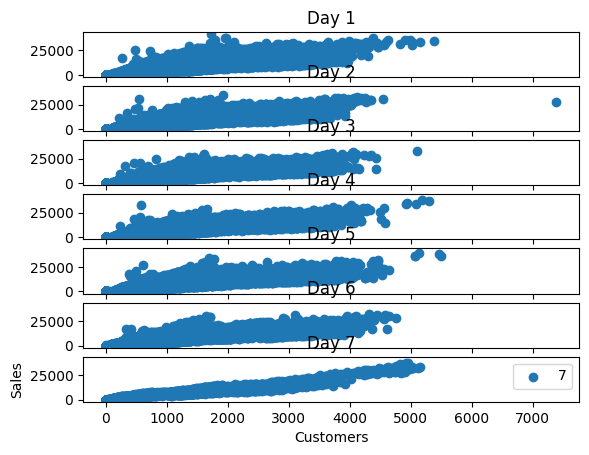

In [ ]:
#Trend for sales per day
f, ax = plt.subplots(7, sharex=True, sharey=True)
for i in range(1, 8):
    mask = train_store_df[train_store_df['DayOfWeek'] == i]
    ax[i - 1].set_title("Day {0}".format(i))
    ax[i - 1].scatter(mask['Customers'], mask['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()#There is a general correlation between sales and customers

<ipython-input-50-0e2615566951>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(train_store_df['Customers'], train_store_df['Sales'], c=train_store_df['DayOfWeek'], alpha=0.7, cmap=plt.cm.get_cmap('viridis'))


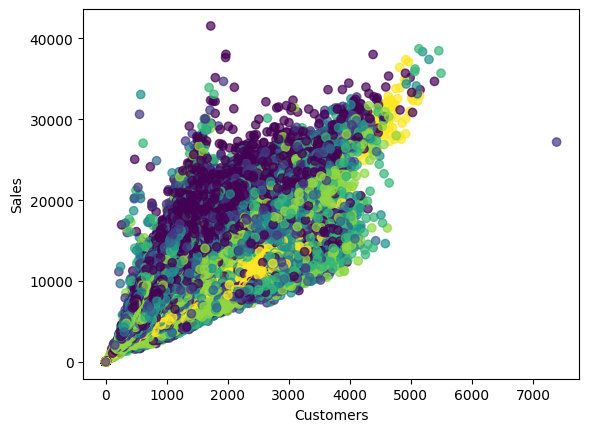

In [ ]:
plt.scatter(train_store_df['Customers'], train_store_df['Sales'], c=train_store_df['DayOfWeek'], alpha=0.7, cmap=plt.cm.get_cmap('viridis'))

plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()#we see that there are various gradients for sales on different days.

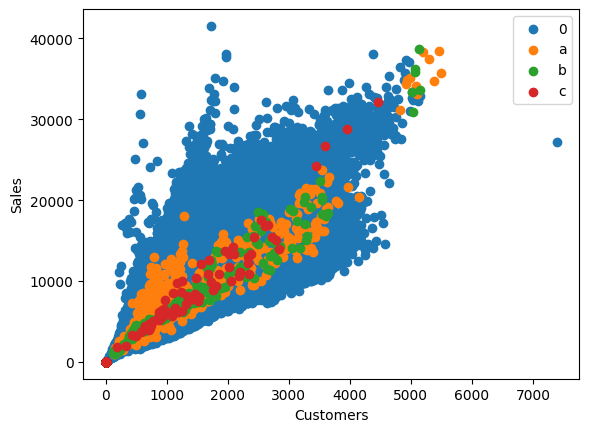

In [ ]:
for i in ["0", "a", "b", "c"]:
    data = train_store_df[train_store_df['StateHoliday'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['Customers'], data['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()
#a = public holiday, b = Easter holiday, c = Christmas, 0 = None
#Christmas and Easter holidays make more impact on sales

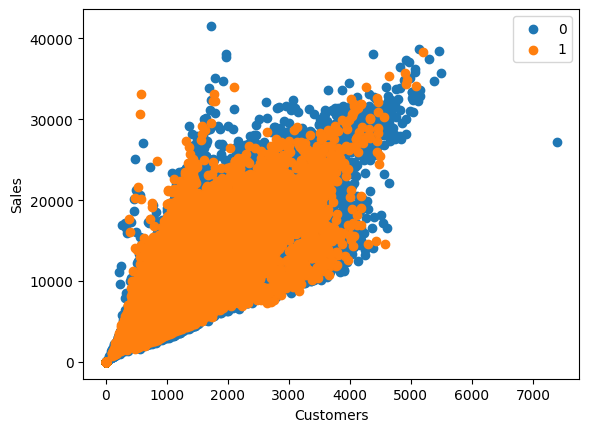

In [ ]:
for i in [0, 1]:
    data = train_store_df[train_store_df['SchoolHoliday'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['Customers'], data['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()
#0 = None, 1 = School holiday
#School holiday does not impact much on sales

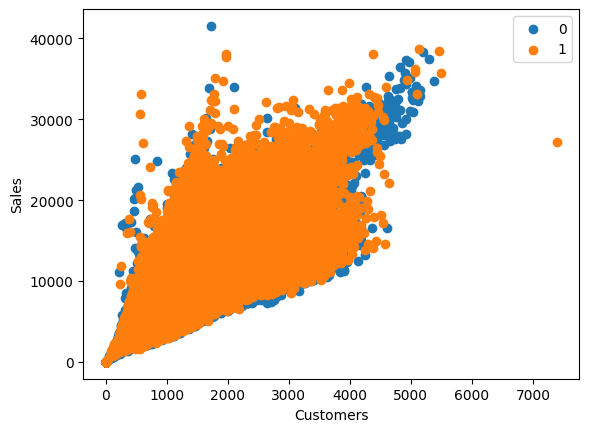

In [ ]:
for i in [0, 1]:
    data = train_store_df[train_store_df['Promo'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['Customers'], data['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()#0 = no Promo 1 = promo
#Promos may have some different effects for two groups of stores.

In [ ]:
train_store_df['SalesPerCustomer'] = train_store_df['Sales'] / train_store_df['Customers']

avg_store = train_store_df.groupby('Store')[['Sales', 'Customers', 'SalesPerCustomer']].mean()
avg_store.rename(columns=lambda x: 'Avg' + x, inplace=True)
store = pd.merge(avg_store.reset_index(), train_store_df, on='Store')
store

Store     AvgSales  AvgCustomers  AvgSalesPerCustomer  DayOfWeek  \
0            1  3945.704883    467.646497             8.393038          5   
1            1  3945.704883    467.646497             8.393038          4   
2            1  3945.704883    467.646497             8.393038          3   
3            1  3945.704883    467.646497             8.393038          2   
4            1  3945.704883    467.646497             8.393038          1   
...        ...          ...           ...                  ...        ...   
1017204   1115  5225.296178    358.687898            14.415954          6   
1017205   1115  5225.296178    358.687898            14.415954          5   
1017206   1115  5225.296178    358.687898            14.415954          4   
1017207   1115  5225.296178    358.687898            14.415954          3   
1017208   1115  5225.296178    358.687898            14.415954          2   

              Date  Sales  Customers  Open  Promo  ... StoreType  Assortment  \
0       2015-07-31   5263        555     1      1  ...         c           a   
1       2015-07-30   5020        546     1      1  ...         c           a   
2       2015-07-29   4782        523     1      1  ...         c           a   
3       2015-07-28   5011        560     1      1  ...         c           a   
4       2015-07-27   6102        612     1      1  ...         c           a   
...            ...    ...        ...   ...    ...  ...       ...         ...   
1017204 2013-01-05   4771        339     1      0  ...         d           c   
1017205 2013-01-04   4540        326     1      0  ...         d           c   
1017206 2013-01-03   4297        300     1      0  ...         d           c   
1017207 2013-01-02   3697        305     1      0  ...         d           c   
1017208 2013-01-01      0          0     0      0  ...         d           c   

        CompetitionDistance CompetitionOpenSinceMonth  \
0                    1270.0                       9.0   
1                    1270.0                       9.0   
2                    1270.0                       9.0   
3                    1270.0                       9.0   
4                    1270.0                       9.0   
...                     ...                       ...   
1017204              5350.0                       9.0   
1017205              5350.0                       9.0   
1017206              5350.0                       9.0   
1017207              5350.0                       9.0   
1017208              5350.0                       9.0   

         CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                          2008.0       0             14.0           2011.0   
1                          2008.0       0             14.0           2011.0   
2                          2008.0       0             14.0           2011.0   
3                          2008.0       0             14.0           2011.0   
4                          2008.0       0             14.0           2011.0   
...                           ...     ...              ...              ...   
1017204                    2013.0       1             22.0           2012.0   
1017205                    2013.0       1             22.0           2012.0   
1017206                    2013.0       1             22.0           2012.0   
1017207                    2013.0       1             22.0           2012.0   
1017208                    2013.0       1             22.0           2012.0   

            PromoInterval  SalesPerCustomer  
0         Jan,Apr,Jul,Oct          9.482883  
1         Jan,Apr,Jul,Oct          9.194139  
2         Jan,Apr,Jul,Oct          9.143403  
3         Jan,Apr,Jul,Oct          8.948214  
4         Jan,Apr,Jul,Oct          9.970588  
...                   ...               ...  
1017204  Mar,Jun,Sept,Dec         14.073746  
1017205  Mar,Jun,Sept,Dec         13.926380  
1017206  Mar,Jun,Sept,Dec         14.323333  
1017207  Mar,Jun,Sept,Dec    

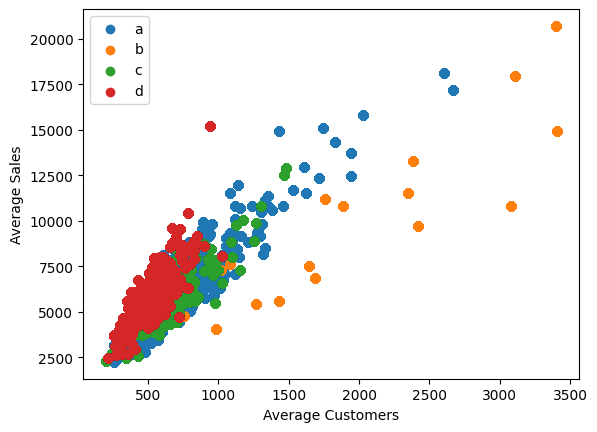

In [ ]:
for i in ['a', 'b', 'c', 'd']:
    data = store[store['StoreType'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['AvgCustomers'], data['AvgSales'], label=i)

plt.legend()
plt.xlabel('Average Customers')
plt.ylabel('Average Sales')
plt.show()
#we are able to tell that certain store types' customers spend less, like 'b'.

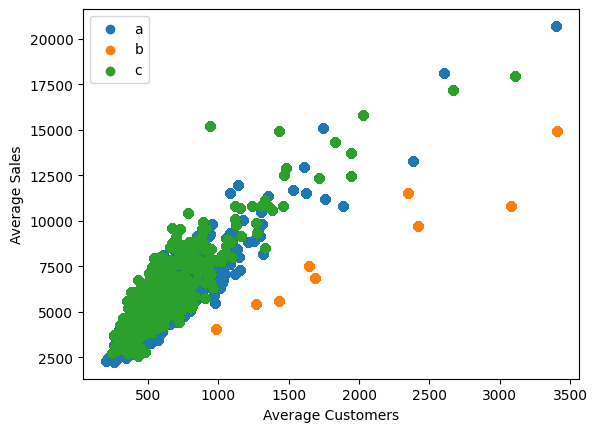

In [ ]:
for i in ['a', 'b', 'c']:
    data = store[store['Assortment'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['AvgCustomers'], data['AvgSales'], label=i)

plt.legend()
plt.xlabel('Average Customers')
plt.ylabel('Average Sales')
plt.show()#we are able to tell that certain assortments' customers spend less, like 'b'

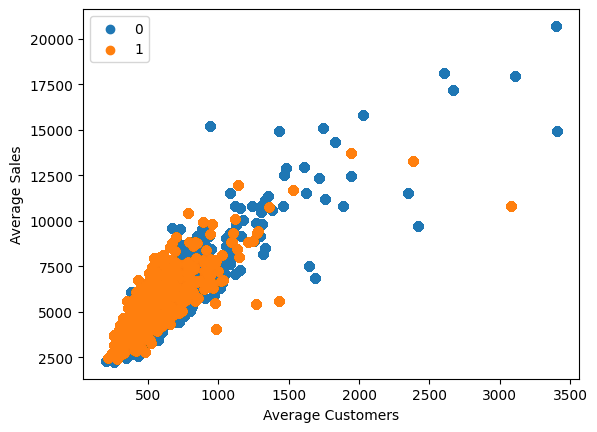

In [ ]:
for i in [0, 1]:
    data = store[store['Promo2'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['AvgCustomers'], data['AvgSales'], label=i)

plt.legend()
plt.xlabel('Average Customers')
plt.ylabel('Average Sales')
plt.show()
#it would seem that promo2 would boost sales per customer.
#0 = without promo2 1 = with promo2

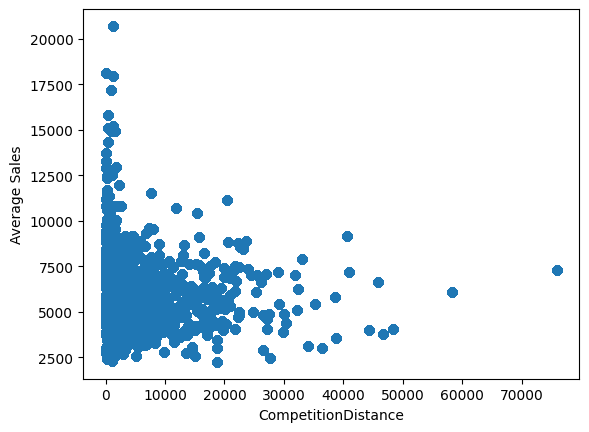

In [ ]:
plt.scatter(store['CompetitionDistance'], store['AvgSales'])

plt.xlabel('CompetitionDistance')
plt.ylabel('Average Sales')
plt.show()#Closer competition means more profits

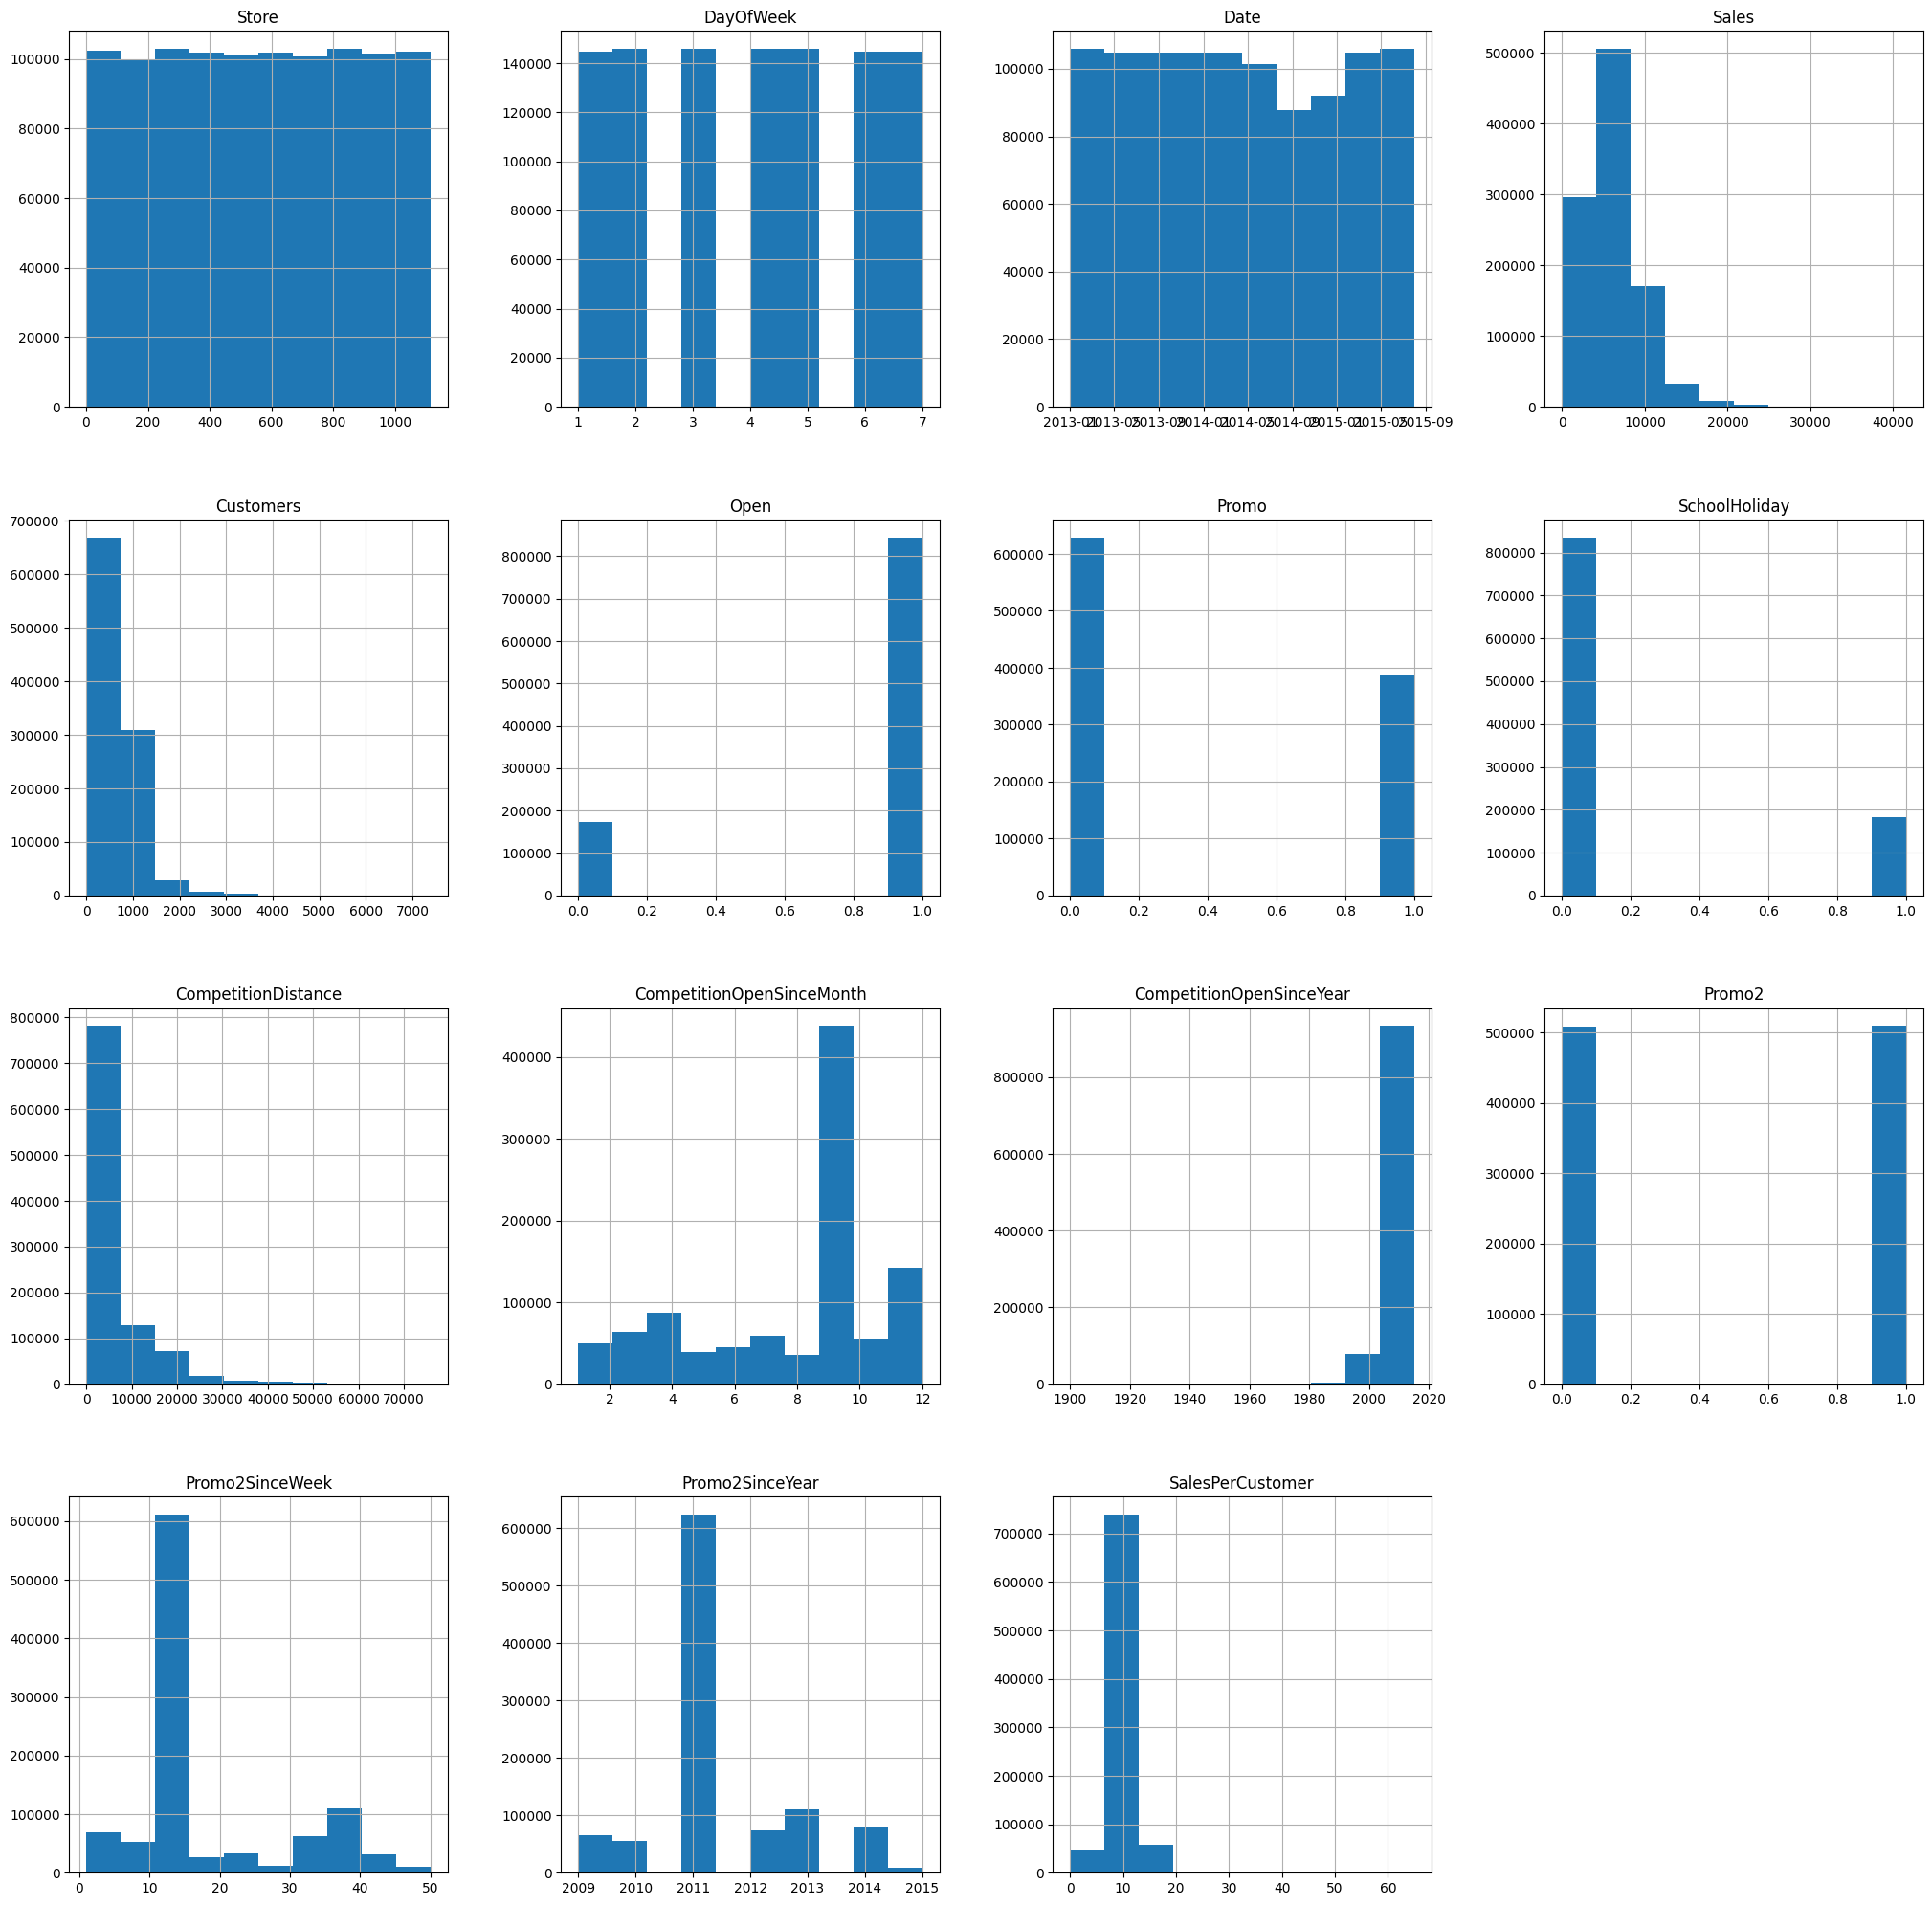

In [ ]:
train_store_df.hist(figsize=(25,25))
plt.show()

##Univariate Analysis

In [ ]:
train_store_df.Sales.describe()

count    1.017209e+06
mean     5.773819e+03
std      3.849926e+03
min      0.000000e+00
25%      3.727000e+03
50%      5.744000e+03
75%      7.856000e+03
max      4.155100e+04
Name: Sales, dtype: float64

<ipython-input-64-9215420a9e14>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_store_df['Sales'], bins=30, kde=False)


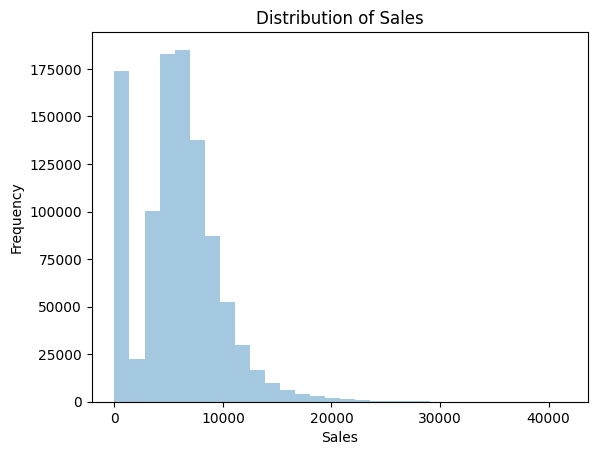

In [ ]:
# Visualize the distribution of the Sales variable
sns.distplot(train_store_df['Sales'], bins=30, kde=False)
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

Text(0.5, 1.0, 'Sales')

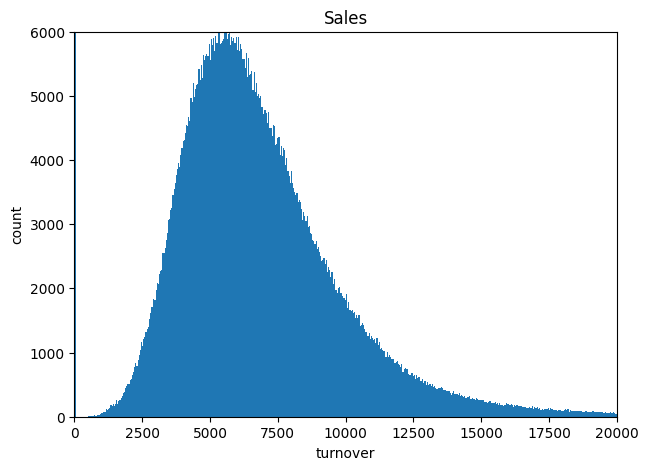

In [ ]:
plt.figure(figsize=(7,5))
plt.hist(train_store_df.Sales, bins=1000)
plt.xlim(0,20000)
plt.ylim(0,6000)
plt.xlabel("turnover")
plt.ylabel("count")
plt.title("Sales")

Sales is positive skewed distribution.

##Date

In [ ]:
train_store_df.Date.describe()

<ipython-input-65-ad63d53e326e>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  train_store_df.Date.describe()


count                 1017209
unique                    942
top       2015-07-31 00:00:00
freq                     1115
first     2013-01-01 00:00:00
last      2015-07-31 00:00:00
Name: Date, dtype: object

In [ ]:
train_store_df.Date.unique()

array(['2015-07-31T00:00:00.000000000', '2015-07-30T00:00:00.000000000',
       '2015-07-29T00:00:00.000000000', '2015-07-28T00:00:00.000000000',
       '2015-07-27T00:00:00.000000000', '2015-07-26T00:00:00.000000000',
       '2015-07-25T00:00:00.000000000', '2015-07-24T00:00:00.000000000',
       '2015-07-23T00:00:00.000000000', '2015-07-22T00:00:00.000000000',
       '2015-07-21T00:00:00.000000000', '2015-07-20T00:00:00.000000000',
       '2015-07-19T00:00:00.000000000', '2015-07-18T00:00:00.000000000',
       '2015-07-17T00:00:00.000000000', '2015-07-16T00:00:00.000000000',
       '2015-07-15T00:00:00.000000000', '2015-07-14T00:00:00.000000000',
       '2015-07-13T00:00:00.000000000', '2015-07-12T00:00:00.000000000',
       '2015-07-11T00:00:00.000000000', '2015-07-10T00:00:00.000000000',
       '2015-07-09T00:00:00.000000000', '2015-07-08T00:00:00.000000000',
       '2015-07-07T00:00:00.000000000', '2015-07-06T00:00:00.000000000',
       '2015-07-05T00:00:00.000000000', '2015-07-04

In [ ]:
test_store_df.Date.unique()

array(['2015-09-17T00:00:00.000000000', '2015-09-16T00:00:00.000000000',
       '2015-09-15T00:00:00.000000000', '2015-09-14T00:00:00.000000000',
       '2015-09-13T00:00:00.000000000', '2015-09-12T00:00:00.000000000',
       '2015-09-11T00:00:00.000000000', '2015-09-10T00:00:00.000000000',
       '2015-09-09T00:00:00.000000000', '2015-09-08T00:00:00.000000000',
       '2015-09-07T00:00:00.000000000', '2015-09-06T00:00:00.000000000',
       '2015-09-05T00:00:00.000000000', '2015-09-04T00:00:00.000000000',
       '2015-09-03T00:00:00.000000000', '2015-09-02T00:00:00.000000000',
       '2015-09-01T00:00:00.000000000', '2015-08-31T00:00:00.000000000',
       '2015-08-30T00:00:00.000000000', '2015-08-29T00:00:00.000000000',
       '2015-08-28T00:00:00.000000000', '2015-08-27T00:00:00.000000000',
       '2015-08-26T00:00:00.000000000', '2015-08-25T00:00:00.000000000',
       '2015-08-24T00:00:00.000000000', '2015-08-23T00:00:00.000000000',
       '2015-08-22T00:00:00.000000000', '2015-08-21

In [ ]:
#The Date in train data is from 2013-01-01 to 2015-07-31, while the date in test data is from 2015-08-01 to 2015-09-17

##Customers

In [ ]:
train_store_df.Customers.describe()

count    1.017209e+06
mean     6.331459e+02
std      4.644117e+02
min      0.000000e+00
25%      4.050000e+02
50%      6.090000e+02
75%      8.370000e+02
max      7.388000e+03
Name: Customers, dtype: float64

Text(0.5, 1.0, 'Customers')

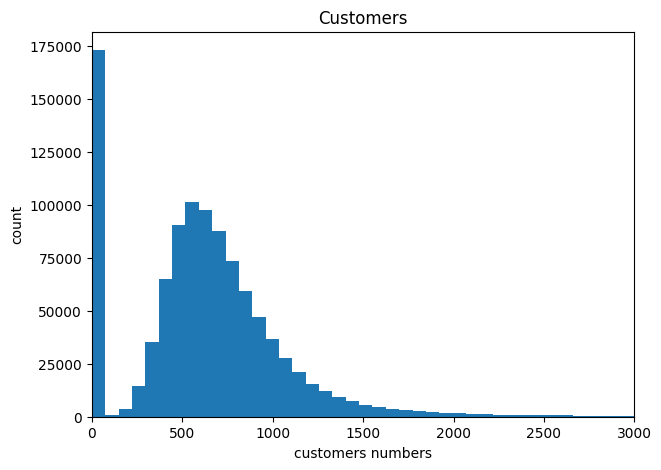

In [ ]:
plt.figure(figsize=(7,5))
plt.hist(train_store_df.Customers, bins=100)
plt.xlim(0,3000)
plt.xlabel("customers numbers")
plt.ylabel("count")
plt.title("Customers")

##CompetitionOpenSinceMonth

Text(0.5, 1.0, 'CompetitionOpenSinceMonth')

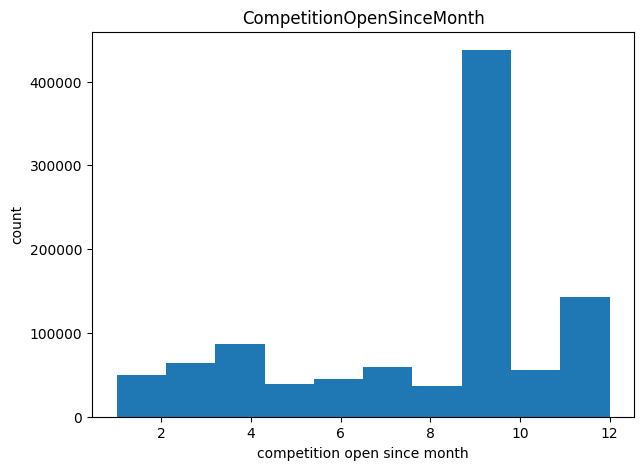

In [ ]:
plt.figure(figsize=(7,5))
plt.hist(train_store_df.CompetitionOpenSinceMonth)
plt.xlabel("competition open since month")
plt.ylabel("count")
plt.title("CompetitionOpenSinceMonth")

In [ ]:
train_store_df.CompetitionOpenSinceMonth.value_counts()#The 9 value accounts for the majority

9.0     437602
4.0      87076
11.0     84455
3.0      63548
7.0      59434
12.0     57896
10.0     55622
6.0      45444
5.0      39608
2.0      37886
8.0      36186
1.0      12452
Name: CompetitionOpenSinceMonth, dtype: int64

##CompetitionOpenSinceYear

In [ ]:
train_store_df.CompetitionOpenSinceYear.unique()

array([2008., 2007., 2006., 2009., 2015., 2013., 2014., 2000., 2011.,
       2010., 2005., 1999., 2003., 2012., 2004., 2002., 1961., 1995.,
       2001., 1990., 1994., 1900., 1998.])

In [ ]:
train_store_df.CompetitionOpenSinceYear.value_counts()

2013.0    398774
2012.0     74299
2014.0     63732
2005.0     56564
2010.0     51258
2009.0     49396
2011.0     49396
2008.0     48476
2007.0     43744
2006.0     42802
2015.0     35060
2002.0     24882
2004.0     19804
2003.0     16794
2001.0     14704
2000.0      9236
1999.0      7352
1990.0      4710
1994.0      1884
1995.0      1700
1961.0       942
1998.0       942
1900.0       758
Name: CompetitionOpenSinceYear, dtype: int64

##Promo2SinceWeek

In [ ]:
train_store_df.Promo2SinceWeek.unique()

array([14., 13.,  1., 45., 40., 26., 22.,  5.,  6., 10., 31., 37.,  9.,
       39., 27., 18., 35., 23., 48., 36., 50., 44., 49., 28.])

In [ ]:
train_store_df.Promo2SinceWeek.value_counts()

14.0    581021
40.0     62598
31.0     39976
10.0     38828
5.0      35818
37.0     32786
1.0      32418
13.0     29820
45.0     29268
22.0     28694
18.0     27318
35.0     22814
9.0      12452
27.0      9626
36.0      9236
48.0      8294
39.0      4732
23.0      4342
44.0      2642
6.0        942
26.0       942
50.0       942
28.0       942
49.0       758
Name: Promo2SinceWeek, dtype: int64

##PromoInterval

In [ ]:
train_store_df.PromoInterval.unique()

array(['Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [ ]:
train_store_df.PromoInterval.value_counts()

Jan,Apr,Jul,Oct     801153
Feb,May,Aug,Nov     118596
Mar,Jun,Sept,Dec     97460
Name: PromoInterval, dtype: int64

##Constructing New Variables

###Construct new variables Year, Month, Day and WeekOfYear based on Date

In [ ]:
#train_store_df
train_store_df['Year'] = train_store_df.Date.dt.year
train_store_df['Month'] = train_store_df.Date.dt.month
train_store_df['Day'] = train_store_df.Date.dt.day
train_store_df['WeekOfYear'] = train_store_df.Date.dt.weekofyear

train_store_df.drop('Date', axis=1, inplace=True)

<ipython-input-80-63d7fdee68a4>:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train_store_df['WeekOfYear'] = train_store_df.Date.dt.weekofyear


In [ ]:
#test_store_df
test_store_df['Year'] = test_store_df.Date.dt.year
test_store_df['Month'] = test_store_df.Date.dt.month
test_store_df['Day'] = test_store_df.Date.dt.day
test_store_df['WeekOfYear'] = test_store_df.Date.dt.weekofyear

test_store_df.drop('Date', axis=1, inplace=True)

<ipython-input-81-359aa7327ed4>:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  test_store_df['WeekOfYear'] = test_store_df.Date.dt.weekofyear


###Construct new variables CompetitionOpen

In [ ]:

#train_store_df
train_store_df['CompetitionOpen'] = 12*(train_store_df.Year - train_store_df.CompetitionOpenSinceYear) + \
                                   (train_store_df.Month - train_store_df.CompetitionOpenSinceMonth)
#test_store_df
test_store_df['CompetitionOpen'] = 12*(test_store_df.Year - test_store_df.CompetitionOpenSinceYear) + \
                                   (test_store_df.Month - test_store_df.CompetitionOpenSinceMonth)

CompetitionOpen = 12*(Year - CompetitionOpenSinceYear) + (Month - CompetitionOpenSinceMonth)

This formula calculates the number of months since the competition near the store was opened.

###Construct new variables PromoOpen

In [ ]:
#train_store_df
train_store_df['PromoOpen'] = 12*(train_store_df.Year - train_store_df.Promo2SinceYear) + \
                                 (train_store_df.WeekOfYear - train_store_df.Promo2SinceWeek) / 4.0

train_store_df['PromoOpen'] = train_store_df.PromoOpen.apply(lambda x: x if x > 0 else 0)
train_store_df.loc[train_store_df.Promo2SinceYear == 0, 'PromoOpen'] = 0

#test_store_df
test_store_df['PromoOpen'] = 12*(test_store_df.Year - test_store_df.Promo2SinceYear) + \
                                (test_store_df.WeekOfYear - test_store_df.Promo2SinceWeek) / 4.0

test_store_df['PromoOpen'] = test_store_df.PromoOpen.apply(lambda x: x if x > 0 else 0)
test_store_df.loc[test_store_df.Promo2SinceYear == 0, 'PromoOpen'] = 0

The formula used to calculate the PromoOpen feature is:

PromoOpen = 12*(Year - Promo2SinceYear) + (WeekOfYear - Promo2SinceWeek) / 4.0

This formula calculates the number of months (in units of 4 weeks) since the store started running the promotional offer. If the resulting value is less than 0 (i.e., the store has not yet started running the promotion), the PromoOpen value is set to 0.

##Bivariate Analysis

###Sales and Open

In [ ]:
train_store_df[train_store_df.Open == 0].Sales.sum()

0

In [ ]:
train_store_df[(train_store_df.Open == 1) & (train_store_df.Sales == 0)]

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
22589       25          4      0          0     1      0            0   
22590       25          3      0          0     1      0            0   
25212       28          4      0          0     1      1            0   
25213       28          3      0          0     1      1            0   
25214       28          2      0          0     1      1            0   
51491       57          2      0          0     1      1            0   
92570      102          4      0          0     1      0            0   
92582      102          6      0          0     1      0            0   
205303     227          4      0          0     1      0            0   
210424     232          4      0          0     1      1            0   
215530     238          4      0          0     1      0            0   
235476     259          4      0          0     1      1            0   
274736     303          4      0          0     1      0            0   
297110     327          3      0          0     1      0            0   
308819     339          4      0          0     1      0            0   
308820     339          3      0          0     1      0            0   
321411     353          6      0          0     1      0            0   
324624     357          1      0          0     1      0            0   
331720     364          3      0          0     1      0            0   
331721     364          2      0          0     1      0            0   
352576     387          4      0          0     1      0            0   
356674     391          3      0          0     1      1            0   
499043     548          5      0          0     1      1            0   
537239     589          1      0          0     1      1            0   
567892     623          6      0          0     1      0            0   
567893     623          5      0          0     1      1            0   
601963     661          5      0          0     1      1            0   
604061     663          1      0          0     1      0            0   
606010     665          6      0          0     1      0            0   
606011     665          5      0          0     1      0            0   
613301     674          4      0          0     1      0            0   
620396     681          5      0          0     1      0            0   
636348     699          4      0          0     1      1            0   
637900     700          3      0          0     1      1            0   
644401     708          3      0          0     1      1            0   
694235     762          4      0          0     1      0            0   
760375     835          4      0          0     1      0            0   
760376     835          3      0          0     1      0            0   
774487     850          6      0          0     1      0            0   
803779     882          3      0          0     1      0            0   
808305     887          3      0          0     1      0            0   
842281     925          4      0          0     1      1            0   
844494     927          4      0          0     1      0            0   
864013     948          4      0          5     1      1            0   
884745     971          5      0          0     1      0            0   
896163     983          6      0          0     1      0            0   
896164     983          5      0          0     1      0            0   
898930     986          2      0          0     1      1            0   
927132    1017          4      0          0     1      1            0   
927133    1017          3      0          0     1      1            0   
947634    1039          3      0          0     1      0            0   
947635    1039          2      0          0     1      0            0   
1003330   1100          3      0          0     1      1            0   
1003331   1100          2      0          3     1      1           

Text(0.5, 1.0, 'the sales of open stores')

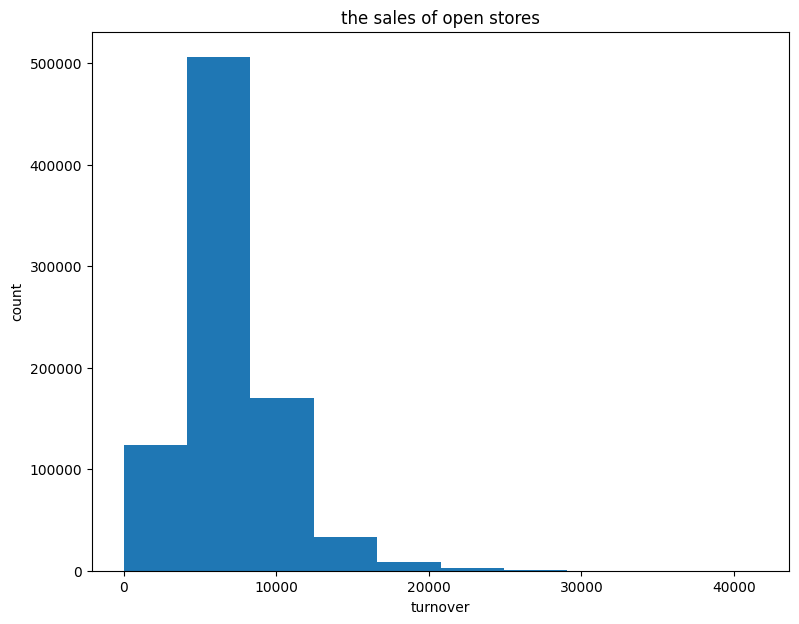

In [ ]:
plt.figure(figsize=(9,7))
plt.hist(train_store_df[train_store_df.Open == 1].Sales)
plt.xlabel("turnover")
plt.ylabel("count")
plt.title("the sales of open stores")

###Analysis of sales!=0 and open != 0

In [ ]:
#sales not equal to zero and store is open

In [ ]:
train_store_sales_df = train_store_df[(train_store_df.Sales != 0) & (train_store_df.Open != 0)]

<ipython-input-88-1aa2534d6416>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat = train_store_df.drop(['Store','Open'], axis=1).corr()


Text(0.5, 1.0, 'Correlation Charts')

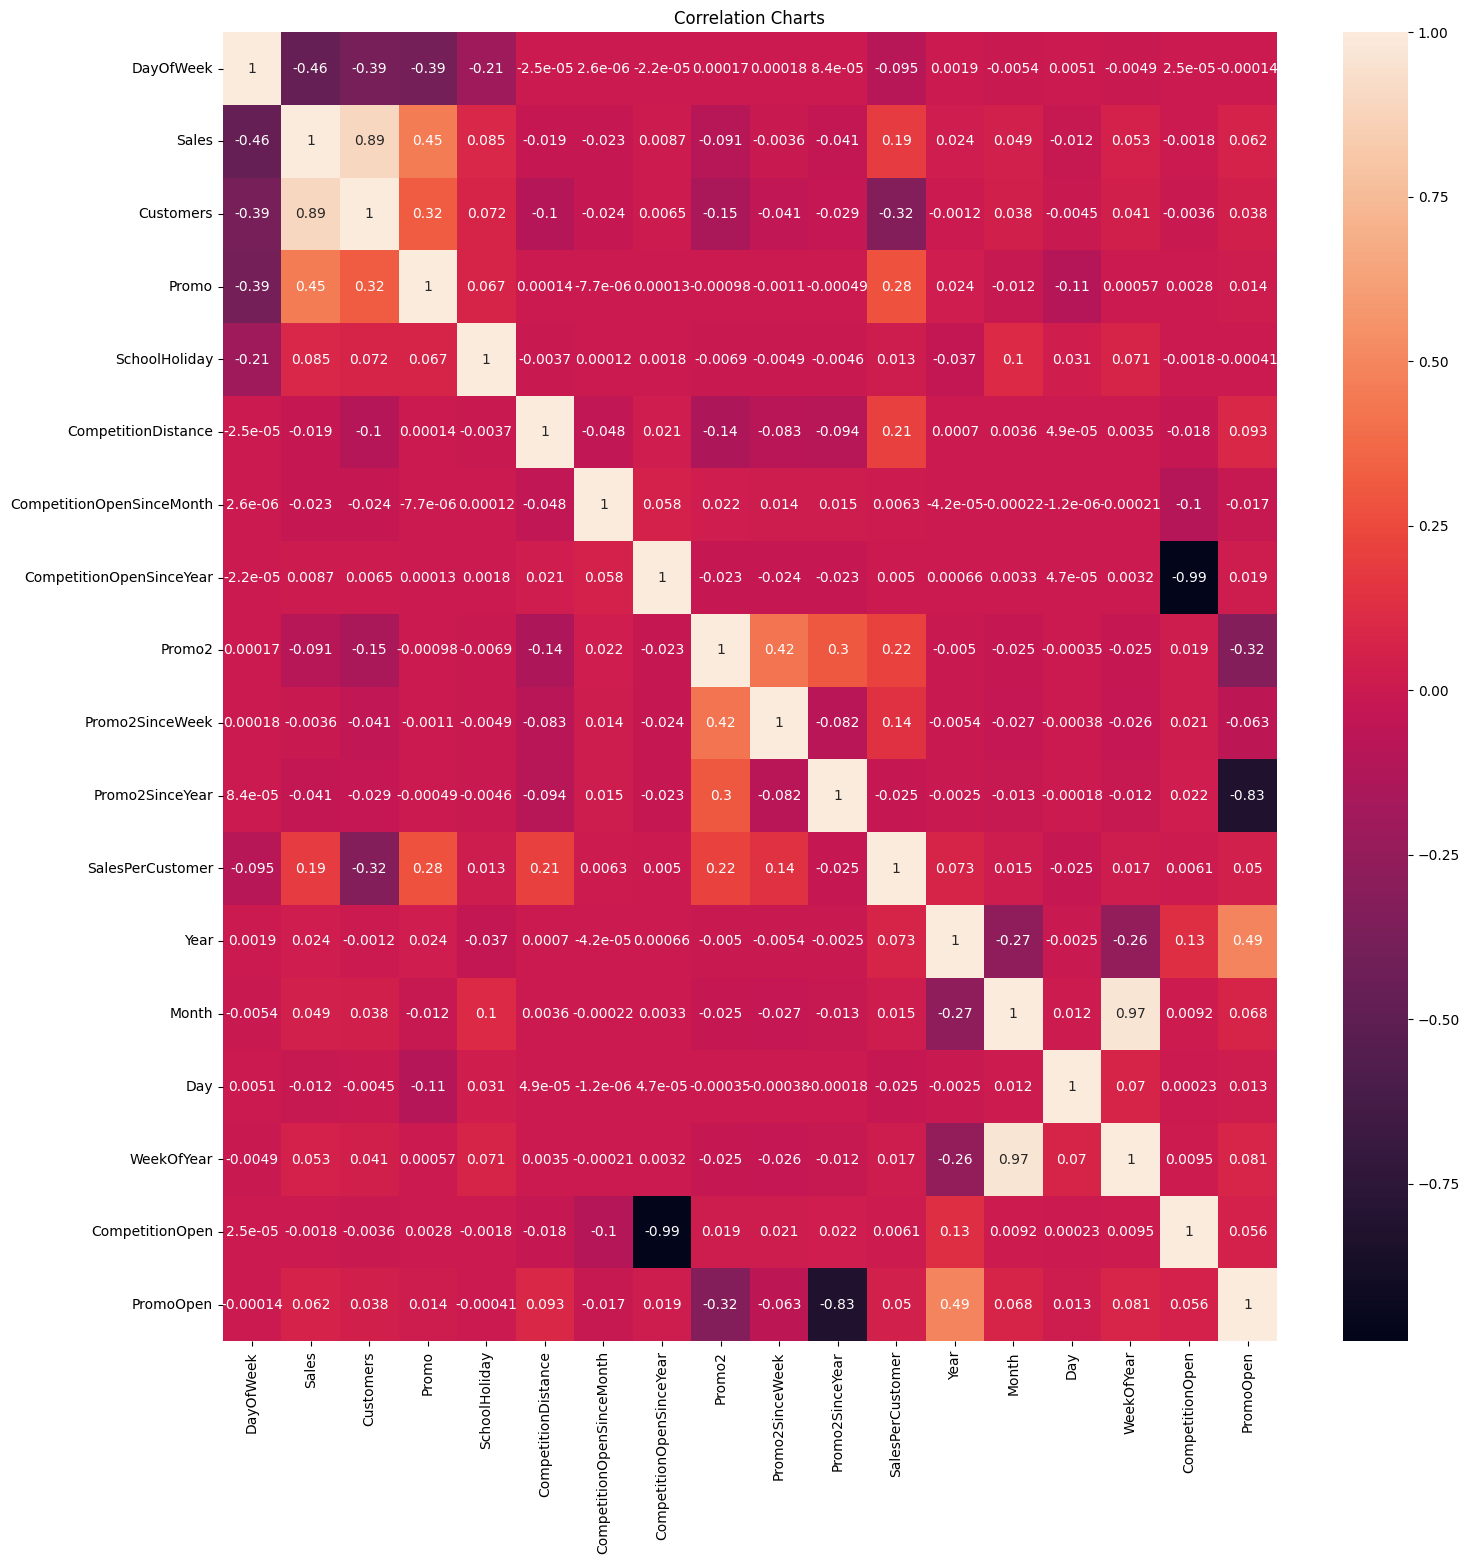

In [ ]:
plt.figure(figsize=(17,17))
corr_mat = train_store_df.drop(['Store','Open'], axis=1).corr()
sns.heatmap(corr_mat,annot=True)
plt.title('Correlation Charts')

###Sales & DayOfWeek

In [ ]:
train_store_sales_df.groupby('DayOfWeek').Sales.mean()

DayOfWeek
1    8216.252259
2    7088.409086
3    6728.786679
4    6768.214973
5    7073.034133
6    5875.084935
7    8224.723908
Name: Sales, dtype: float64

Text(0.5, 1.0, 'Sales & DayOfWeek')

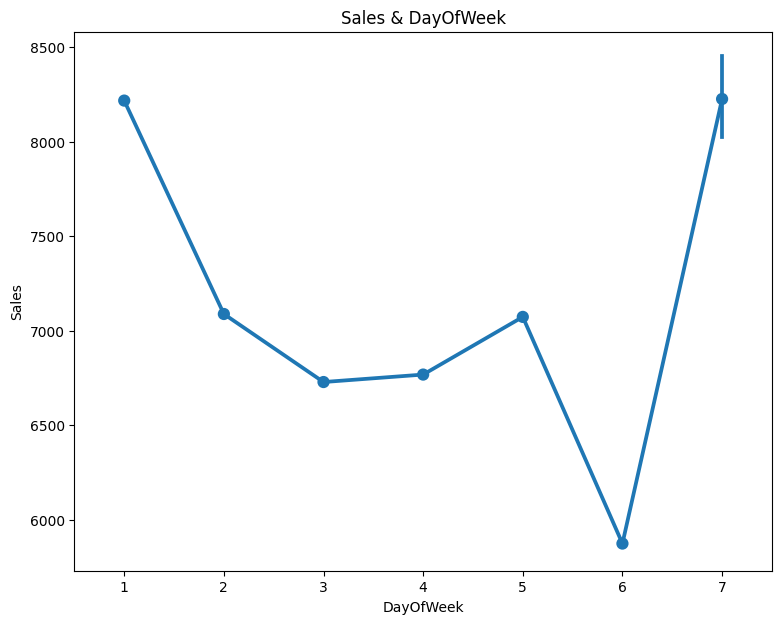

In [ ]:
plt.figure(figsize=(9,7))
sns.pointplot(x = train_store_sales_df['DayOfWeek'], y = train_store_sales_df['Sales'])
plt.title("Sales & DayOfWeek")#Sales on Saturday are the lowest

###Sales & WeekOfYear

Text(0.5, 1.0, 'Sales & WeekOfYear')

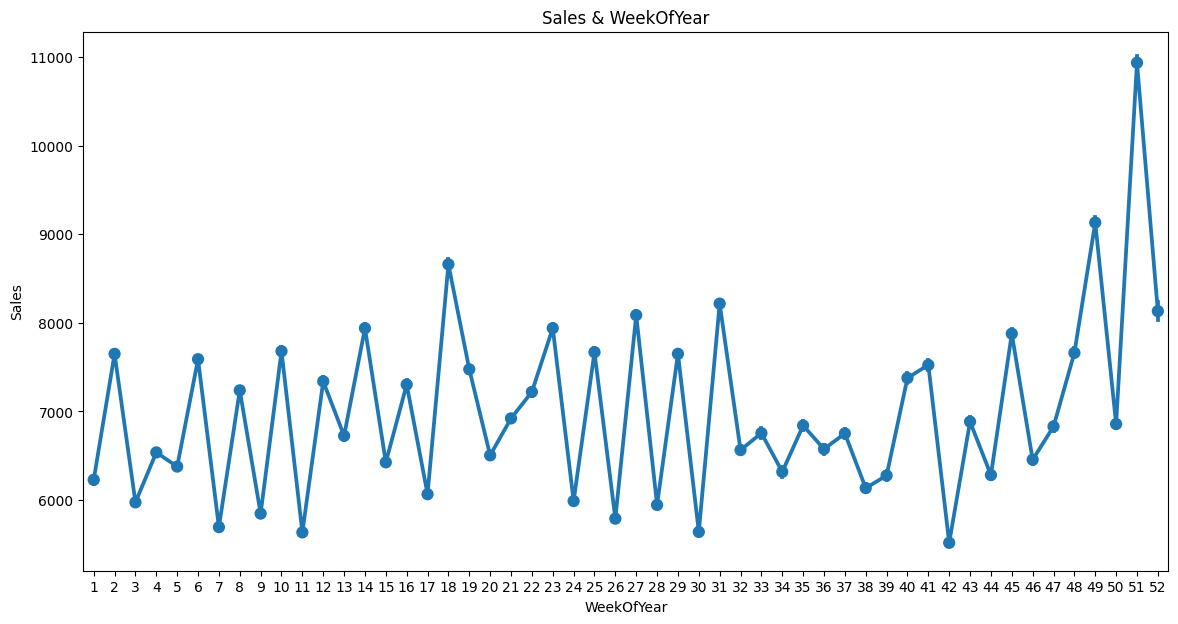

In [ ]:
plt.figure(figsize=(14,7))
sns.pointplot(x = train_store_sales_df['WeekOfYear'], y = train_store_sales_df['Sales'])
plt.title("Sales & WeekOfYear")

###Sales & Year

In [ ]:
train_store_sales_df.groupby('Year').Sales.sum()

Year
2013    2302876084
2014    2180804896
2015    1389499643
Name: Sales, dtype: int64

In [ ]:
plt.figure(figsize=(9,7))
sns.histplot(x = train_store_sales_df['Year'],y = train_store_sales_df['Sales'])
plt.title("Sales & Year")#The three years sales are almost the same

###Sales & Month

Text(0.5, 1.0, 'Sales & Month')

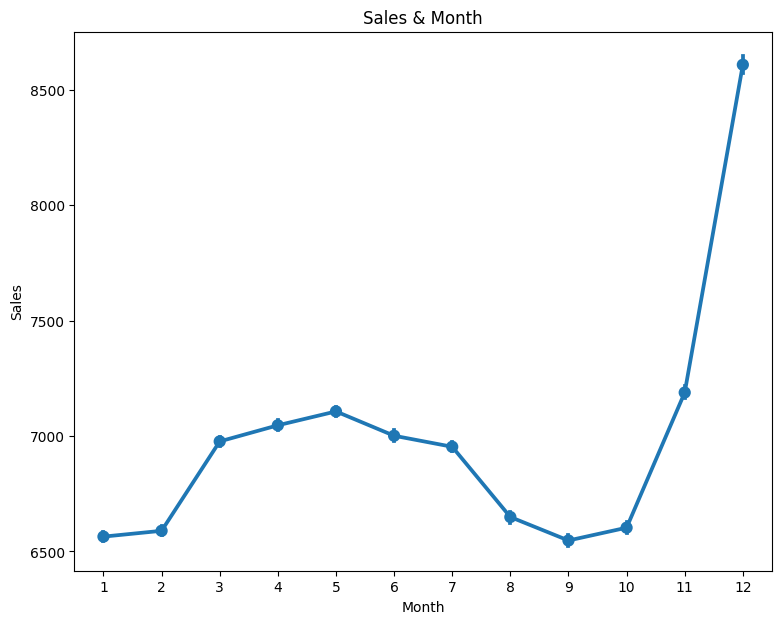

In [ ]:
plt.figure(figsize=(9,7))
sns.pointplot(x = train_store_sales_df['Month'], y = train_store_sales_df['Sales'])
plt.title("Sales & Month")#The December sales is the largest.

###Sales & Day

Text(0.5, 1.0, 'Sales & Day')

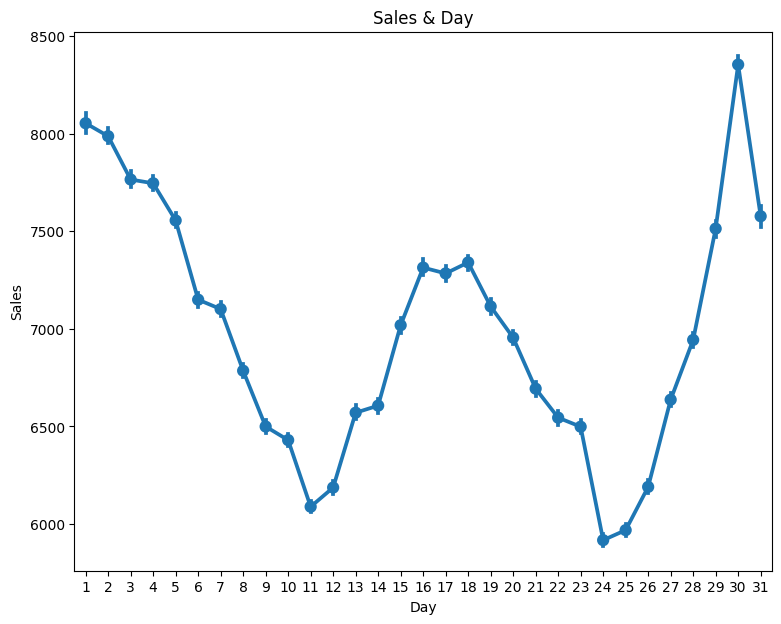

In [ ]:
plt.figure(figsize=(9,7))
sns.pointplot(x = train_store_sales_df['Day'], y = train_store_sales_df['Sales'])
plt.title("Sales & Day")
#we see that sales are the most at the beginning of the month, the monthly, and the end of the month. There is a strong rule between the two variables.

###Sales & Promo

In [ ]:
train_store_sales_df.groupby('Promo').Sales.mean()

Promo
0    5929.826183
1    8228.739731
Name: Sales, dtype: float64

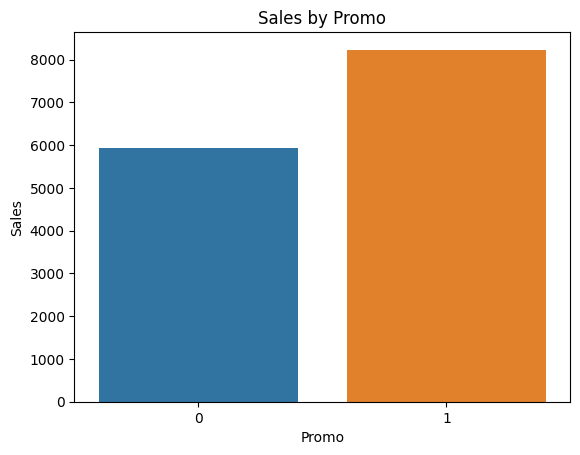

In [ ]:
# Visualize the sales by promo
sales_by_promo = train_store_sales_df.groupby('Promo')['Sales'].mean().reset_index()
sns.barplot(x='Promo', y='Sales', data=sales_by_promo)
plt.title('Sales by Promo')
plt.xlabel('Promo')
plt.ylabel('Sales')
plt.show()

Text(0.5, 1.0, 'Sales & Promo')

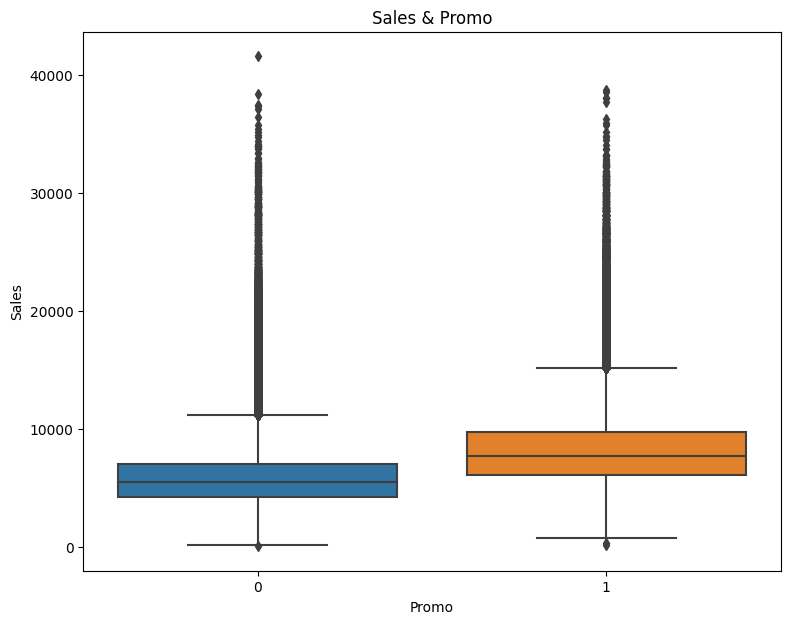

In [ ]:
plt.figure(figsize=(9,7))
sns.boxplot(data=train_store_sales_df, x='Promo', y='Sales')
plt.title("Sales & Promo")#We can know that promotion is benifit to improve sales

###Sales & StoreType

In [ ]:
train_store_sales_df.groupby('StoreType').Sales.mean()

StoreType
a     6925.697986
b    10233.380141
c     6933.126425
d     6822.300064
Name: Sales, dtype: float64

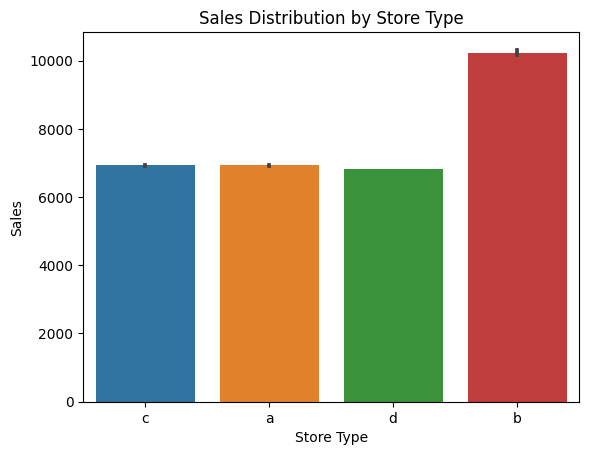

In [ ]:
# Visualize the sales distribution by store type
sns.barplot(x='StoreType', y='Sales', data=train_store_sales_df)
plt.title('Sales Distribution by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.show()

###Sales & CompetitionOpen

Text(0.5, 1.0, 'Sales & CompetitionOpen')

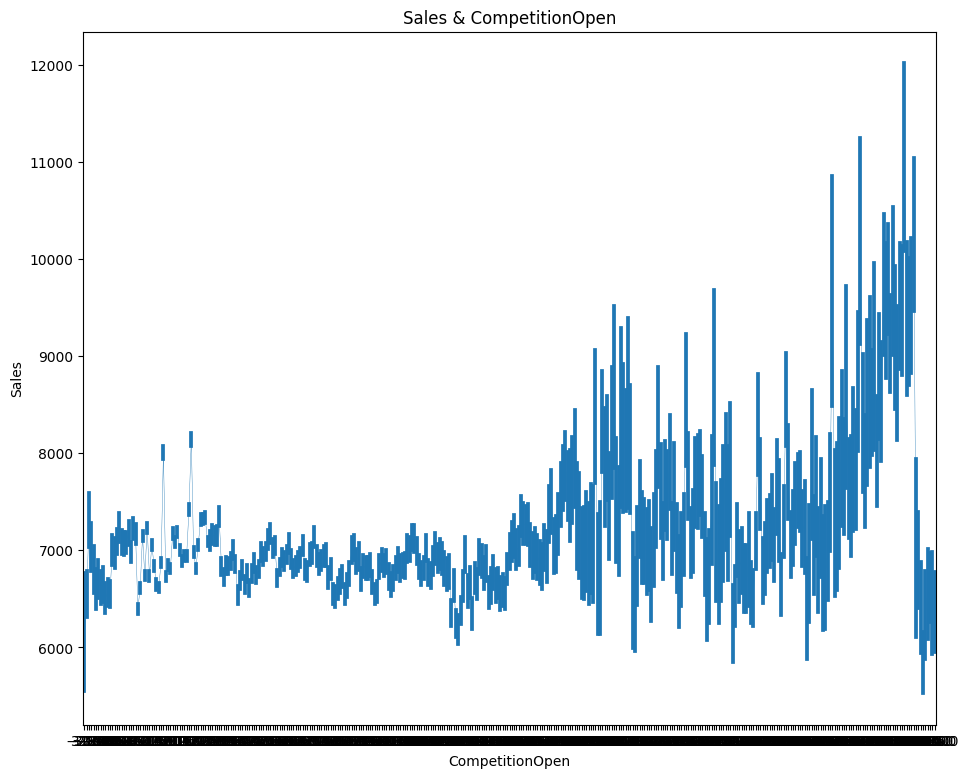

In [ ]:
plt.figure(figsize=(11,9))
sns.pointplot(data=train_store_sales_df, x='CompetitionOpen', y='Sales',scale=0.1)
plt.title("Sales & CompetitionOpen")#There is a weak rule between sales and CompetitionOpen

###Sales & Promo2

In [ ]:
train_store_sales_df.groupby('Promo2').Sales.sum()

Promo2
0    3111542628
1    2761637995
Name: Sales, dtype: int64

Text(0.5, 1.0, 'Sales & Promo2')

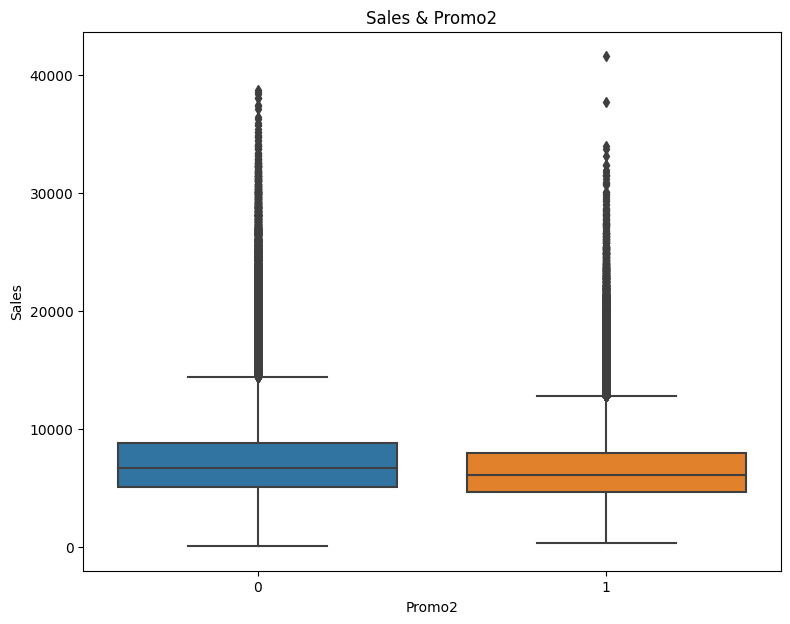

In [ ]:
plt.figure(figsize=(9,7))
sns.boxplot(data=train_store_sales_df, x='Promo2', y='Sales')
plt.title("Sales & Promo2")
#The stores with promos tend to make lower sales. This does not necessary mean that the promos don’t help or are counterproductive.
#They are possibly measures that are taken mainly by stores with low sales in the first place.

###Sales & PromoOpen

Text(0.5, 1.0, 'Sales & PromoOpen')

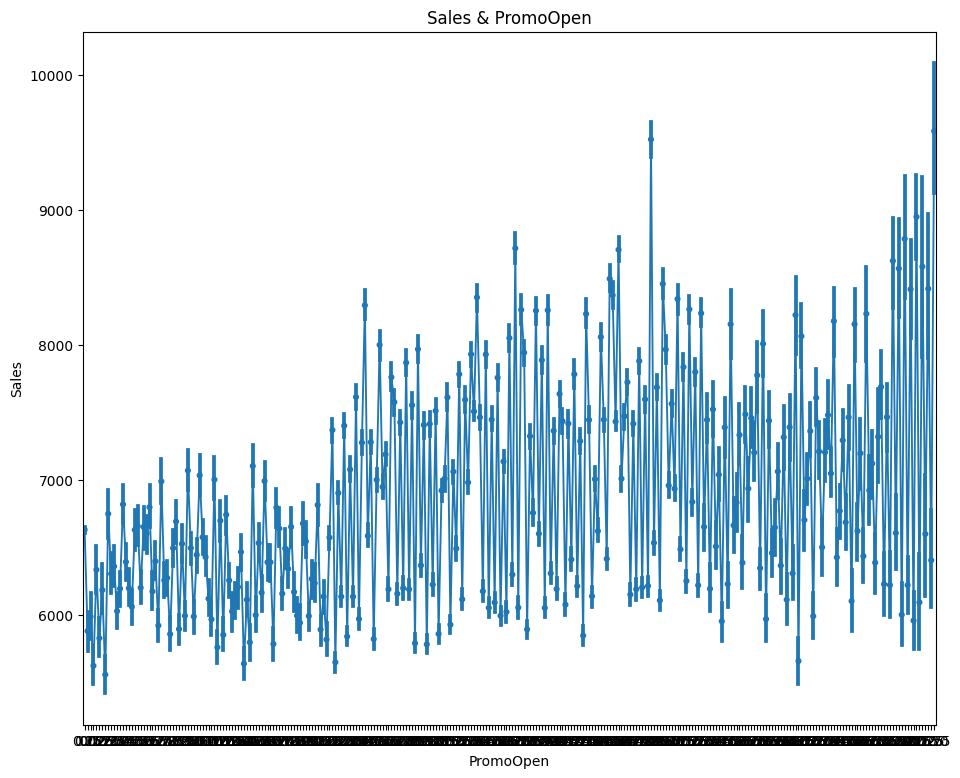

In [ ]:
plt.figure(figsize=(11,9))
sns.pointplot(data=train_store_sales_df, x='PromoOpen', y='Sales',scale=0.5)
plt.title("Sales & PromoOpen")
#It seems that the longer the time is, the bigger the sales are.
#There is no correlation between sales and Promo2SinceYear.

###Sales & PromoInterval

In [ ]:
train_store_sales_df.groupby('PromoInterval').Sales.mean()

PromoInterval
Feb,May,Aug,Nov     6427.367069
Jan,Apr,Jul,Oct     7123.437381
Mar,Jun,Sept,Dec    6215.888185
Name: Sales, dtype: float64

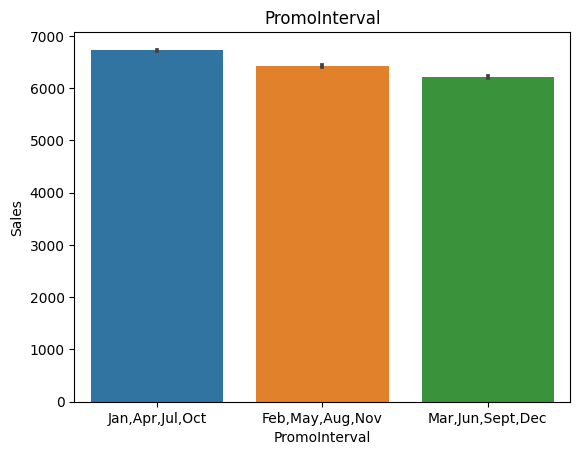

In [ ]:
# Visualize the sales distribution by store type
sns.barplot(x='PromoInterval', y='Sales', data=train_store_sales_df)
plt.title('PromoInterval')
plt.xlabel('PromoInterval')
plt.ylabel('Sales')
plt.show()

From above bivariate analysis, we can see that there is a strong positive correlation between sales and customer. There is a certain relationship between variables Sales and Day, DayofWeek, WeekofYear, CompetitionOpen, PromoOpen.

##Multivariate Anlaysis

###Sales & DayOfWeek & StoreType & Promo

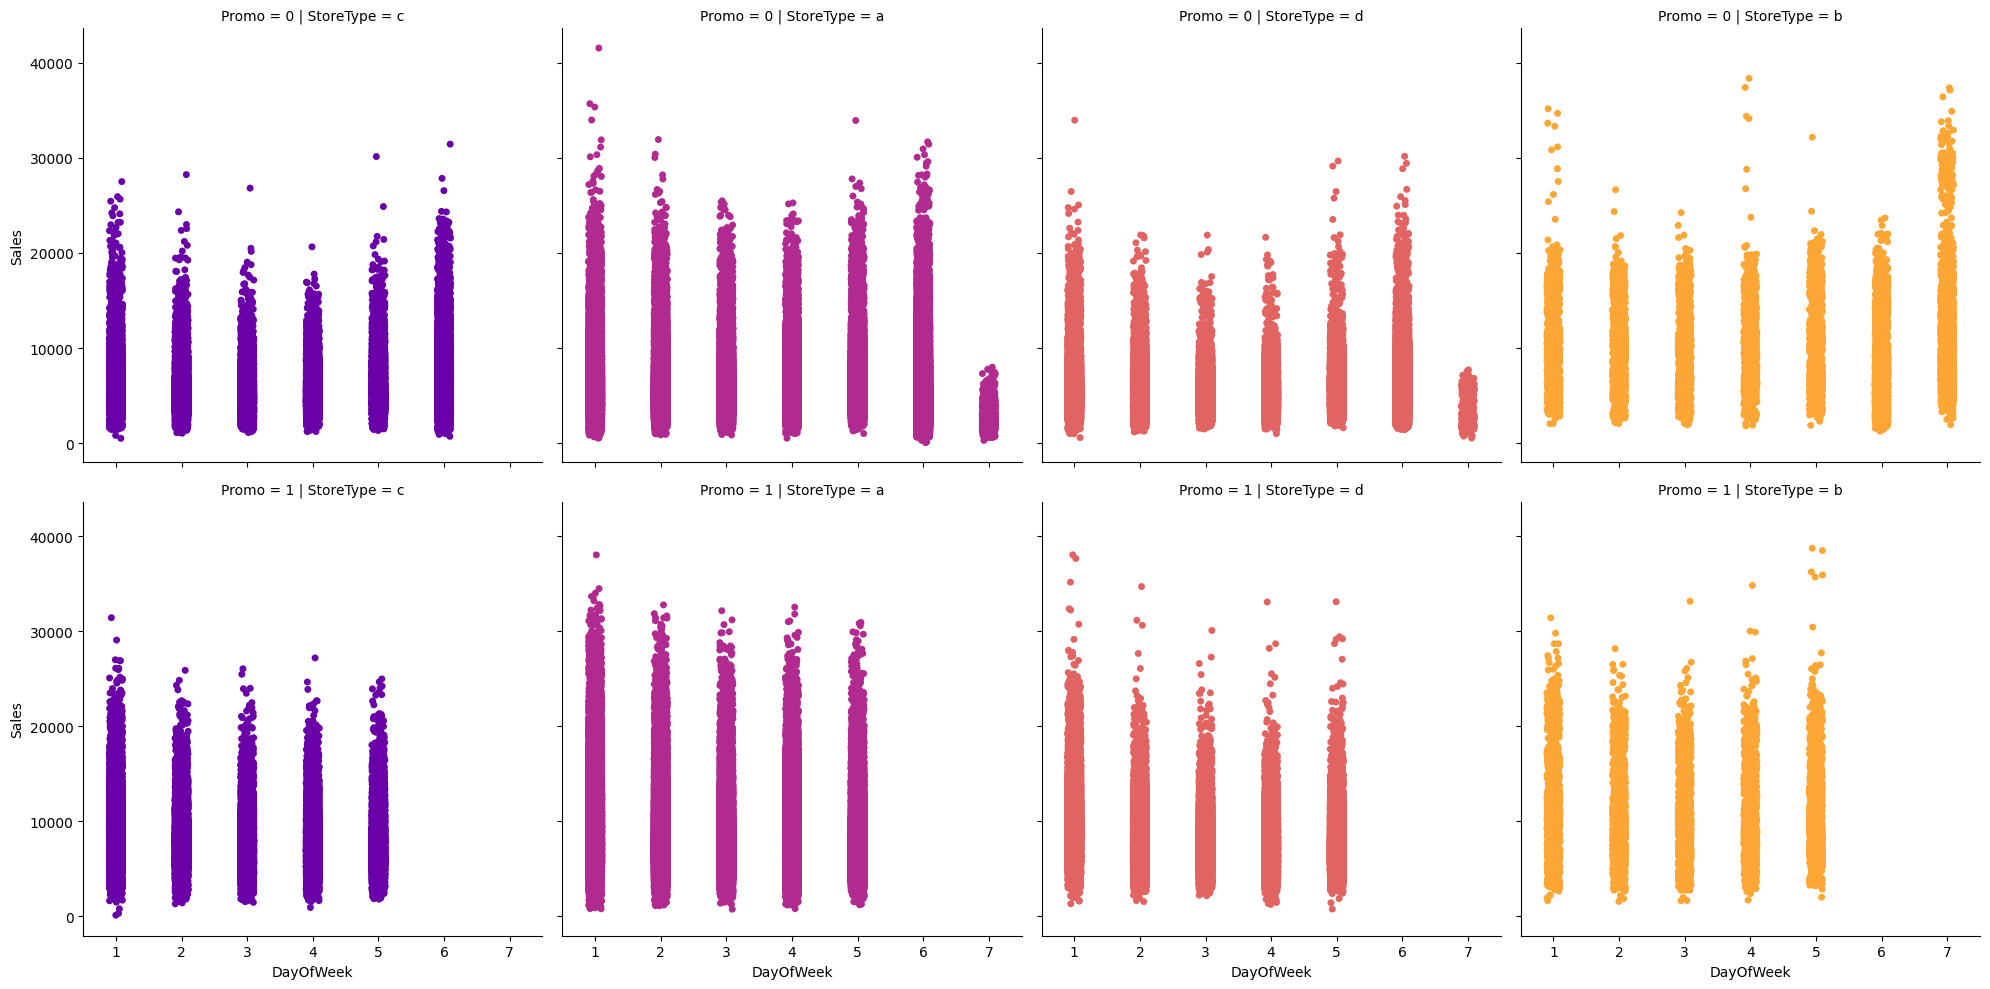

In [ ]:
sns.catplot(data = train_store_sales_df, x = 'DayOfWeek', y = "Sales",
               col = 'StoreType',
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo')#We can see that stores are never promoted at the weekend.

###Sales & Month & StoreType & Promo

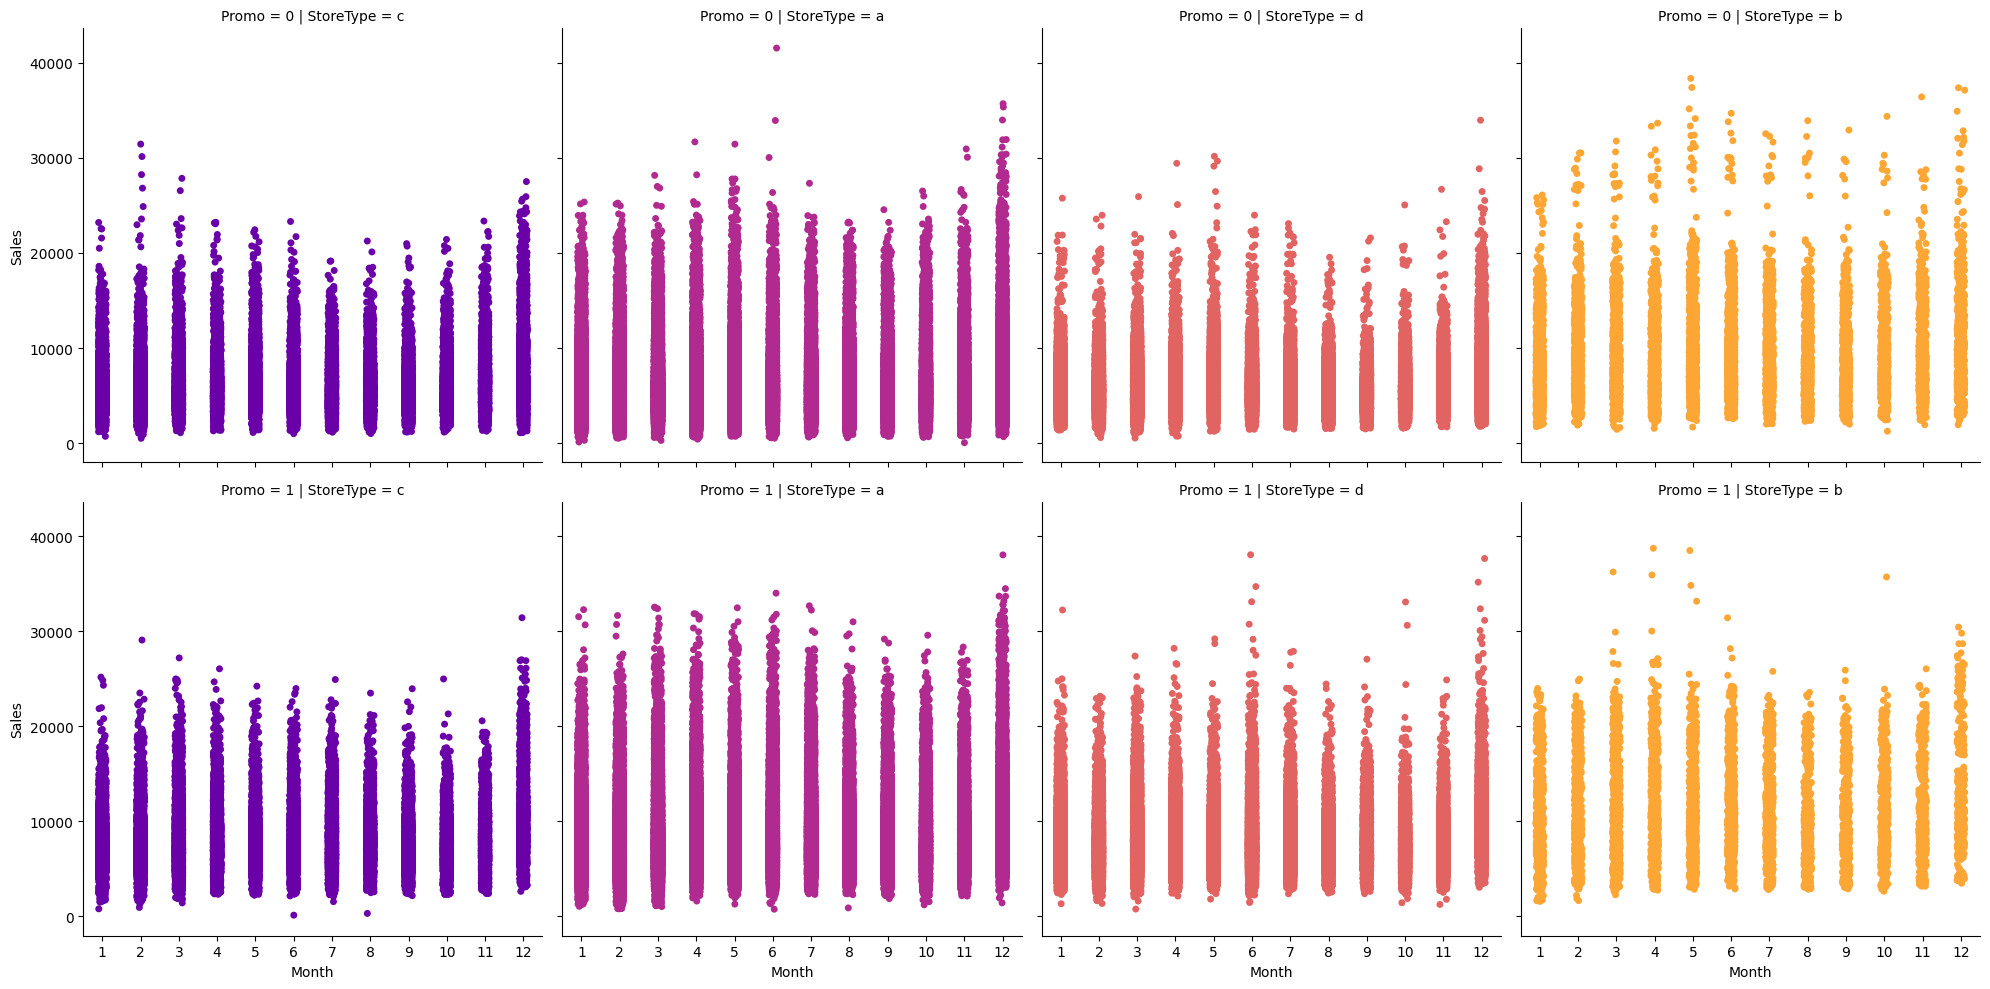

In [ ]:
sns.catplot(data = train_store_sales_df, x = 'Month', y = "Sales",
               col = 'StoreType',
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo')#Sales promotion can improve sales to a certain extent. There is a distinct increase in sales in the fourth quarter.

###Sales & Month & Assortment & StoreType

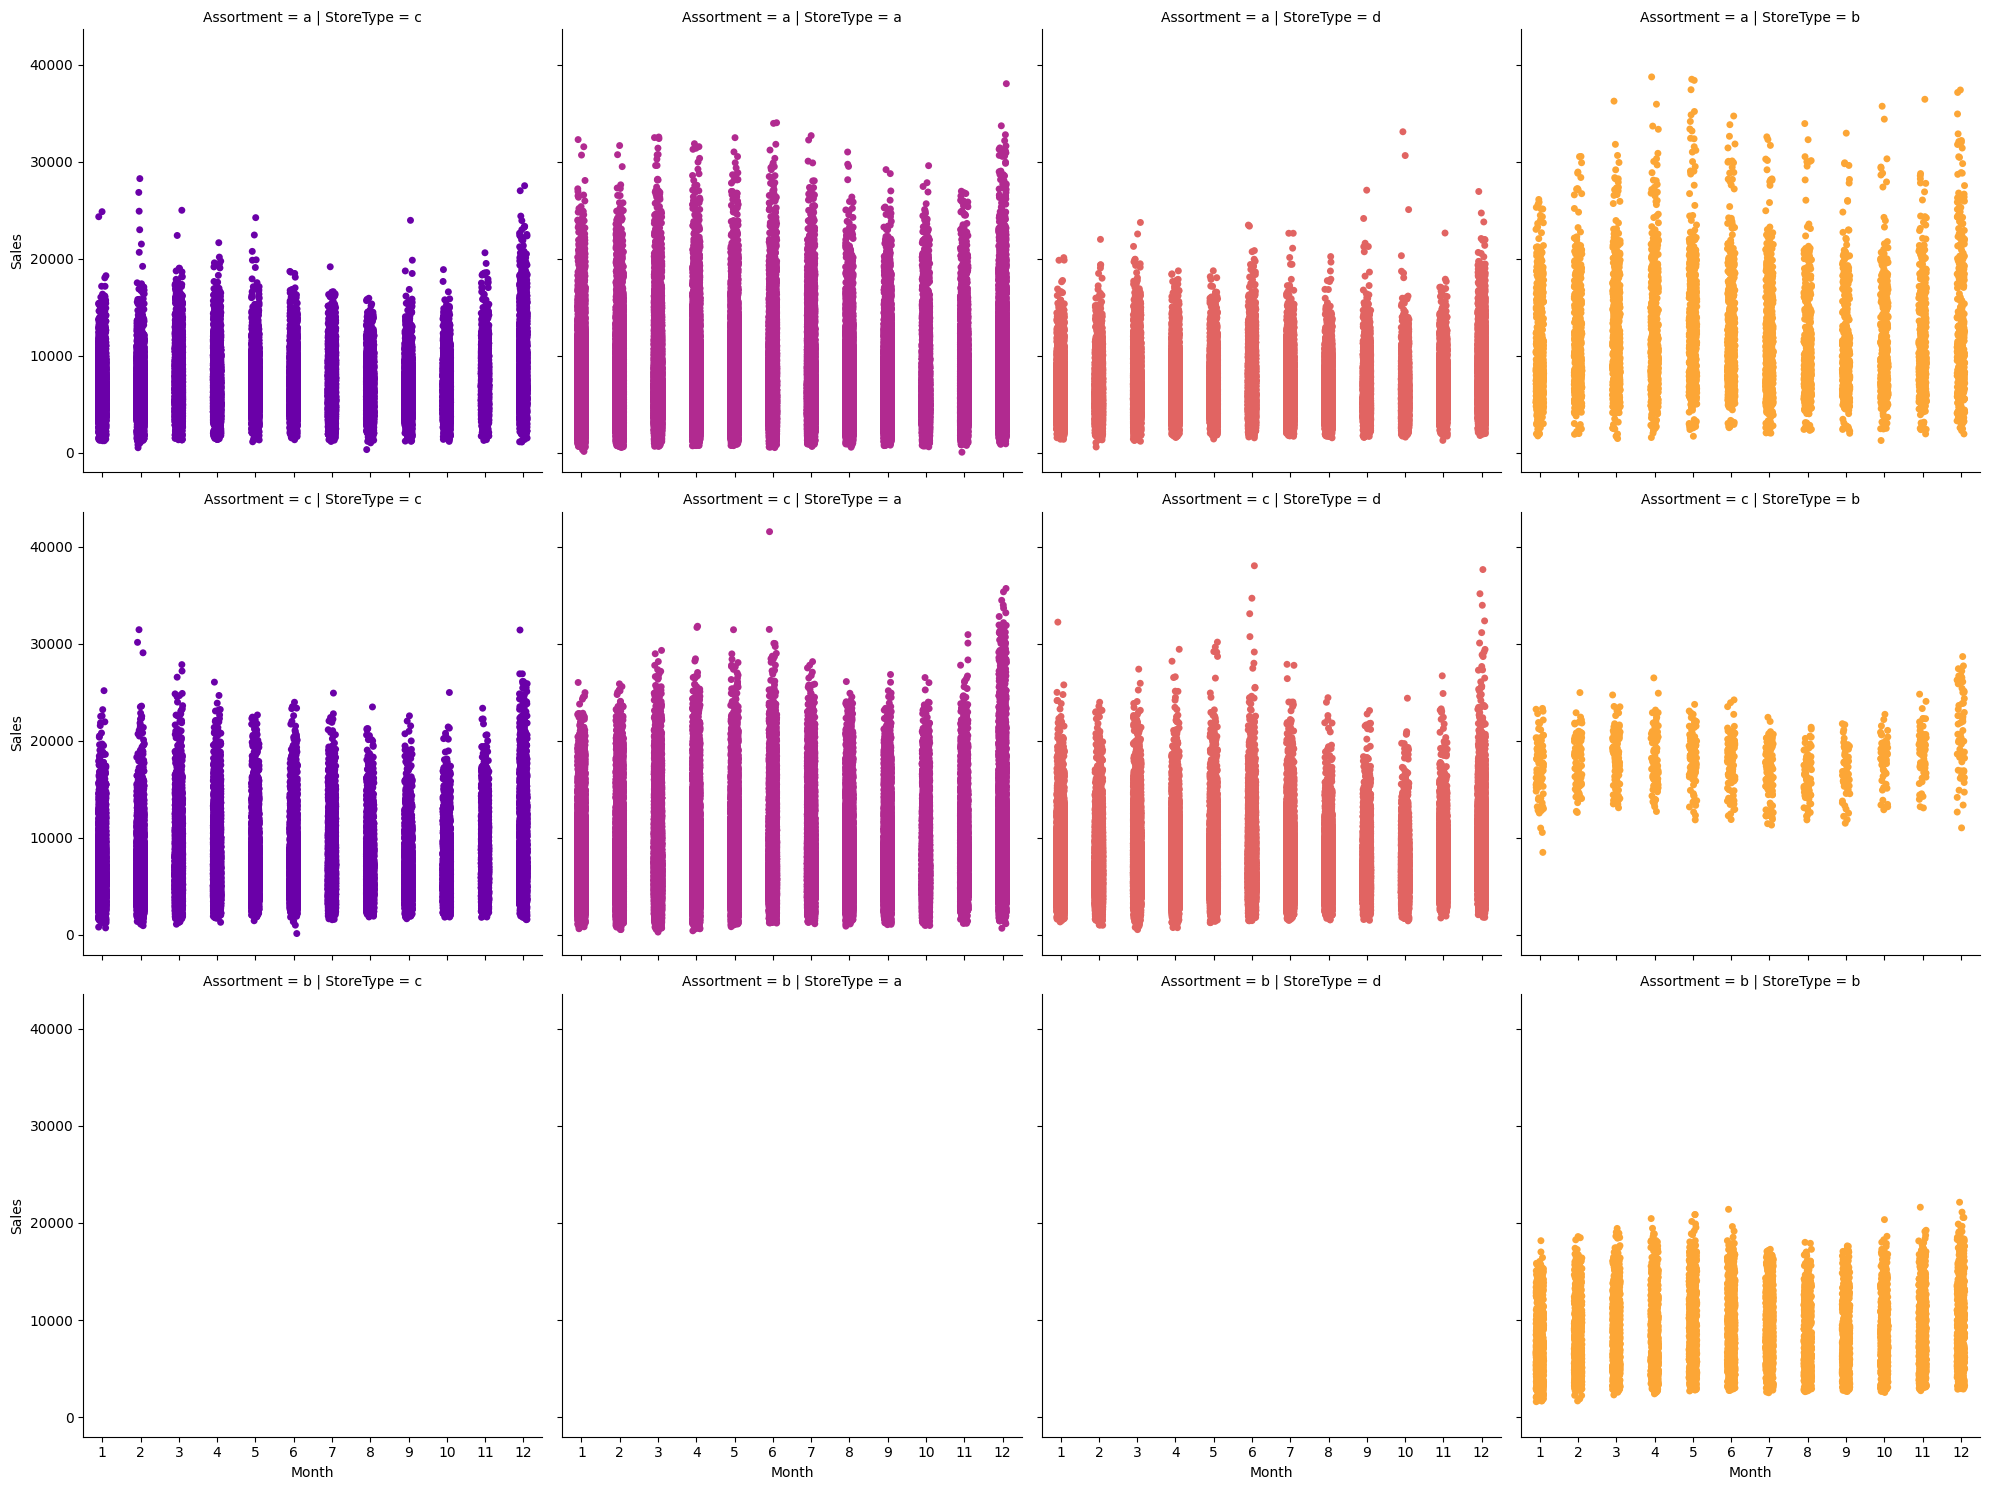

In [ ]:
sns.catplot(data = train_store_sales_df, x = 'Month', y = "Sales",
               col = 'StoreType',
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Assortment')#Only 'b' type stores have 'b' assortment level.

###Sales & Month & DayOfWeek & StoreType

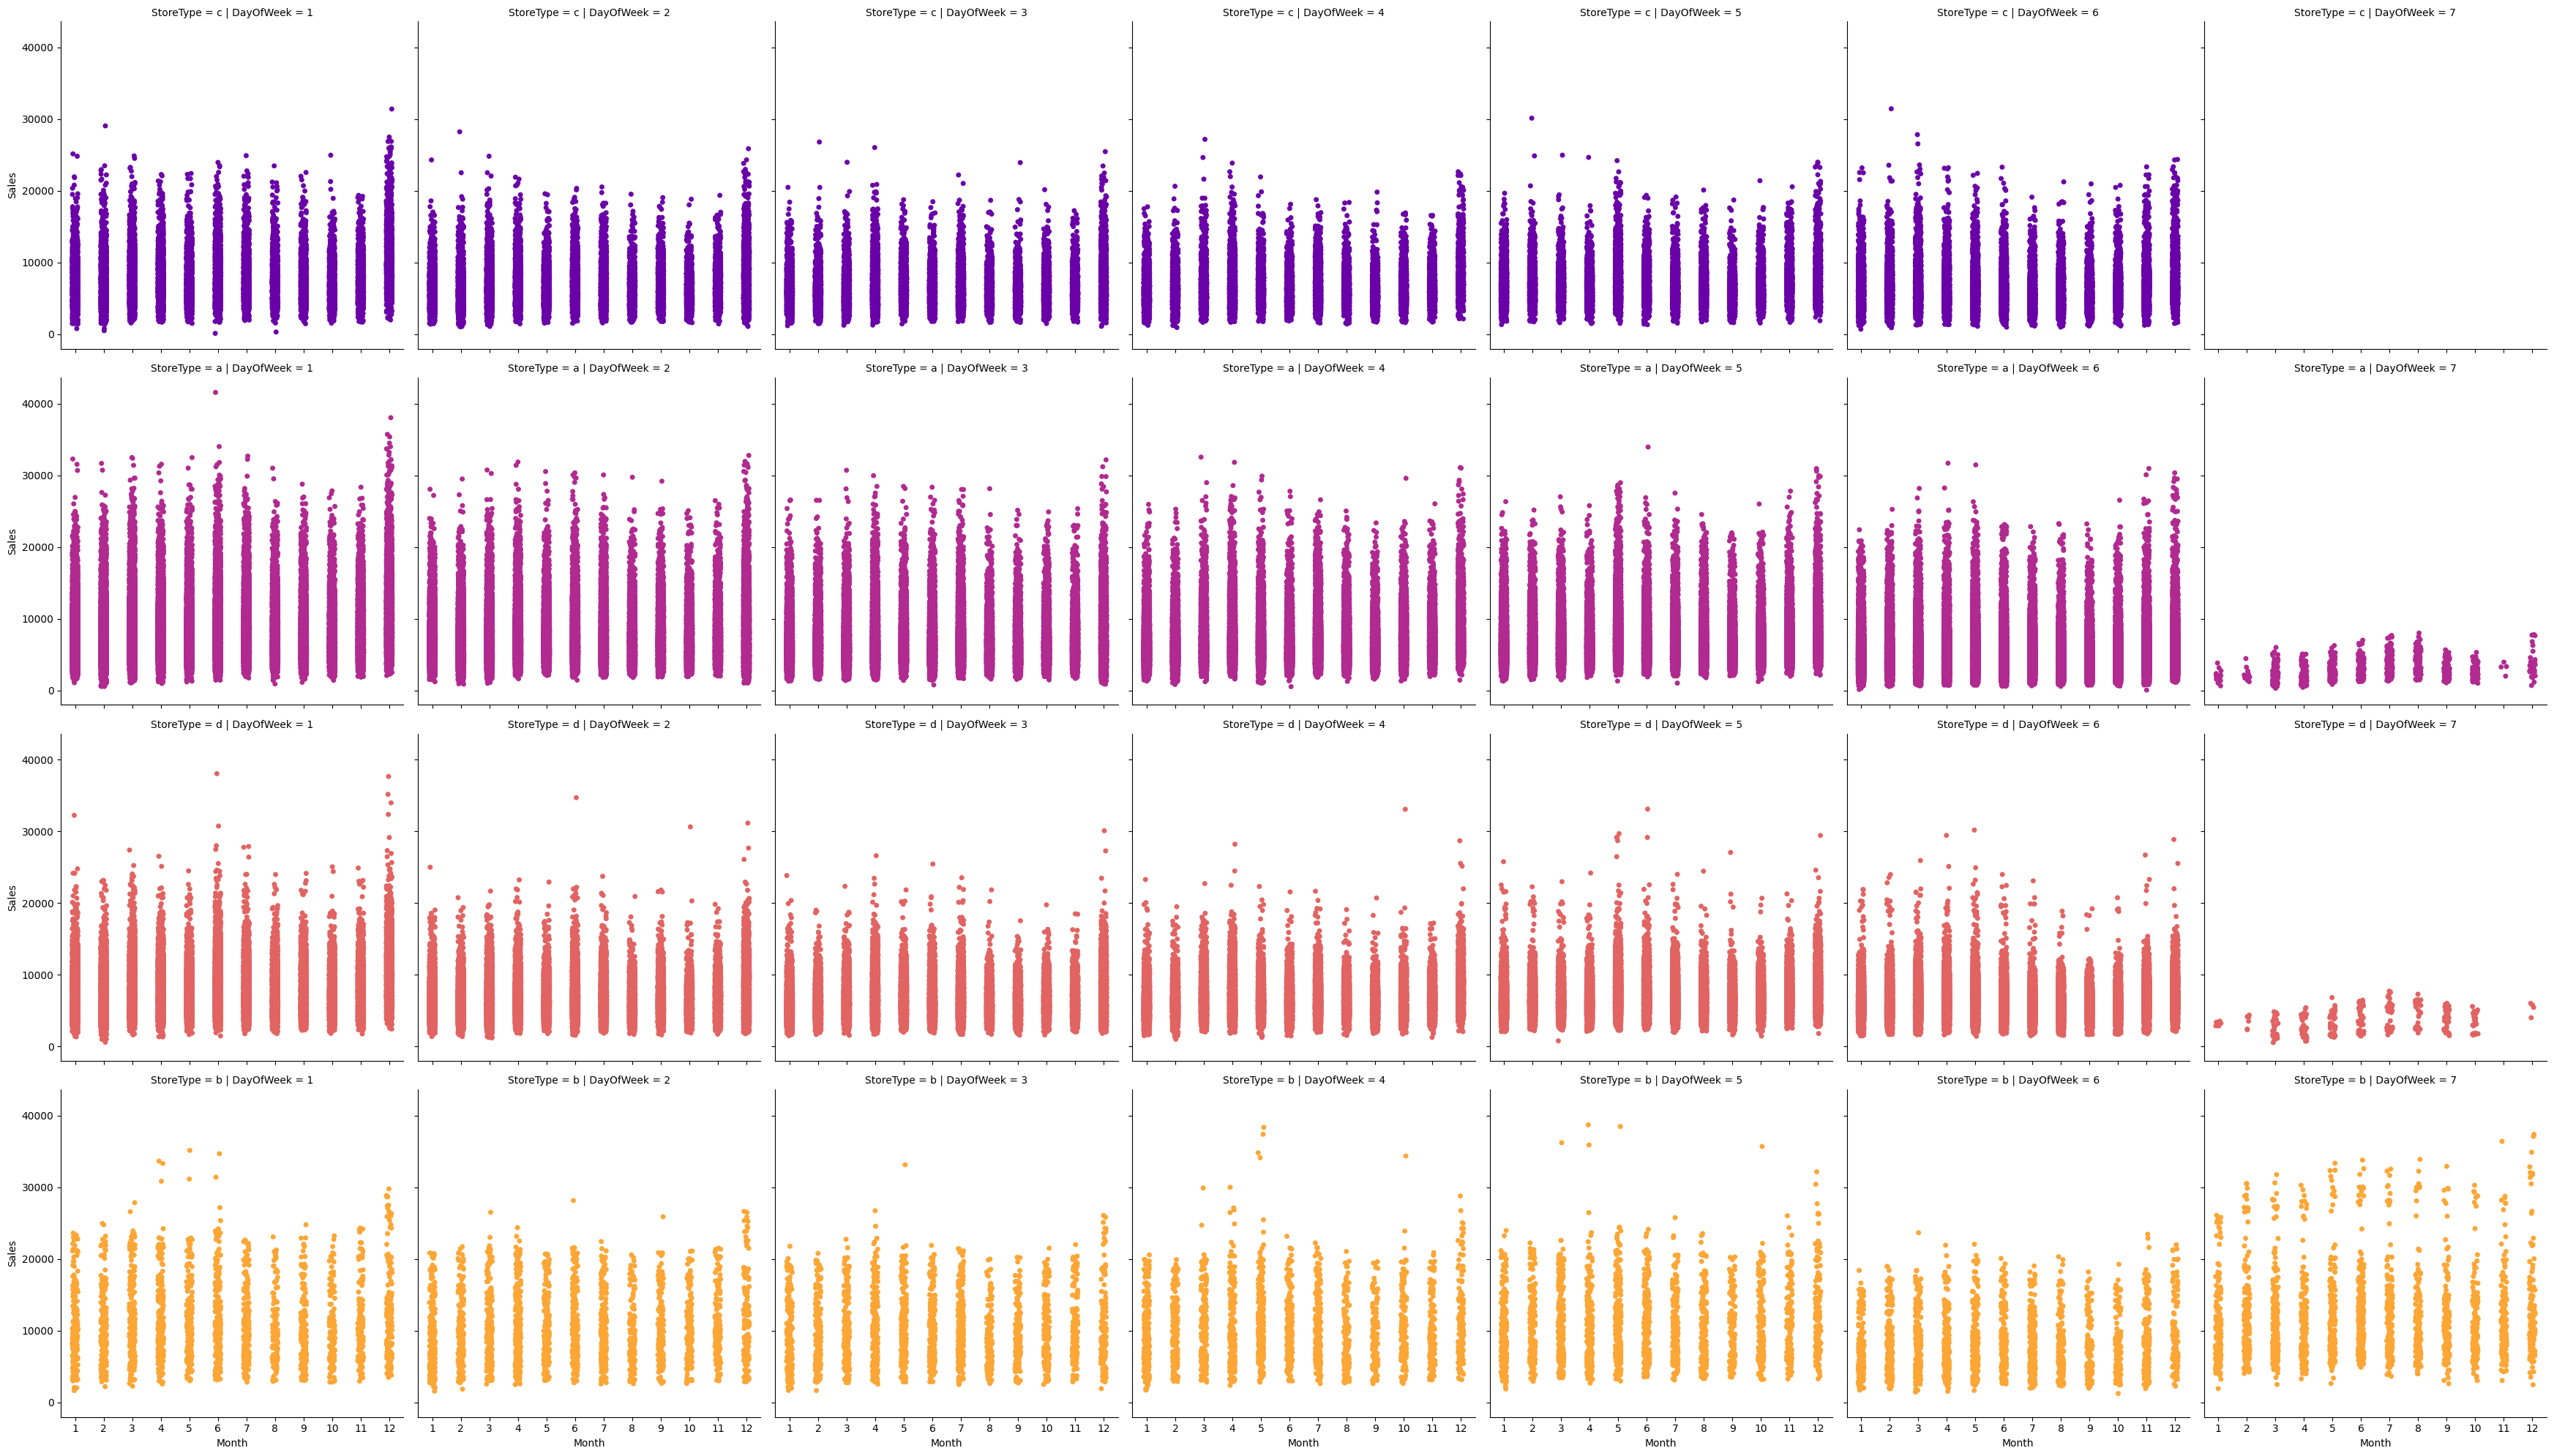

In [ ]:
sns.catplot(data = train_store_sales_df, x = 'Month', y = "Sales",
               col = 'DayOfWeek',
               palette = 'plasma',
               hue = 'StoreType',
               row = 'StoreType')

We see that stores of StoreType C are all closed on Sundays, whereas others are most of the time opened. Interestingly enough, stores of StoreType D are closed on Sundays only from October to December.

###Sales & StateHoliday & Promo & StoreType

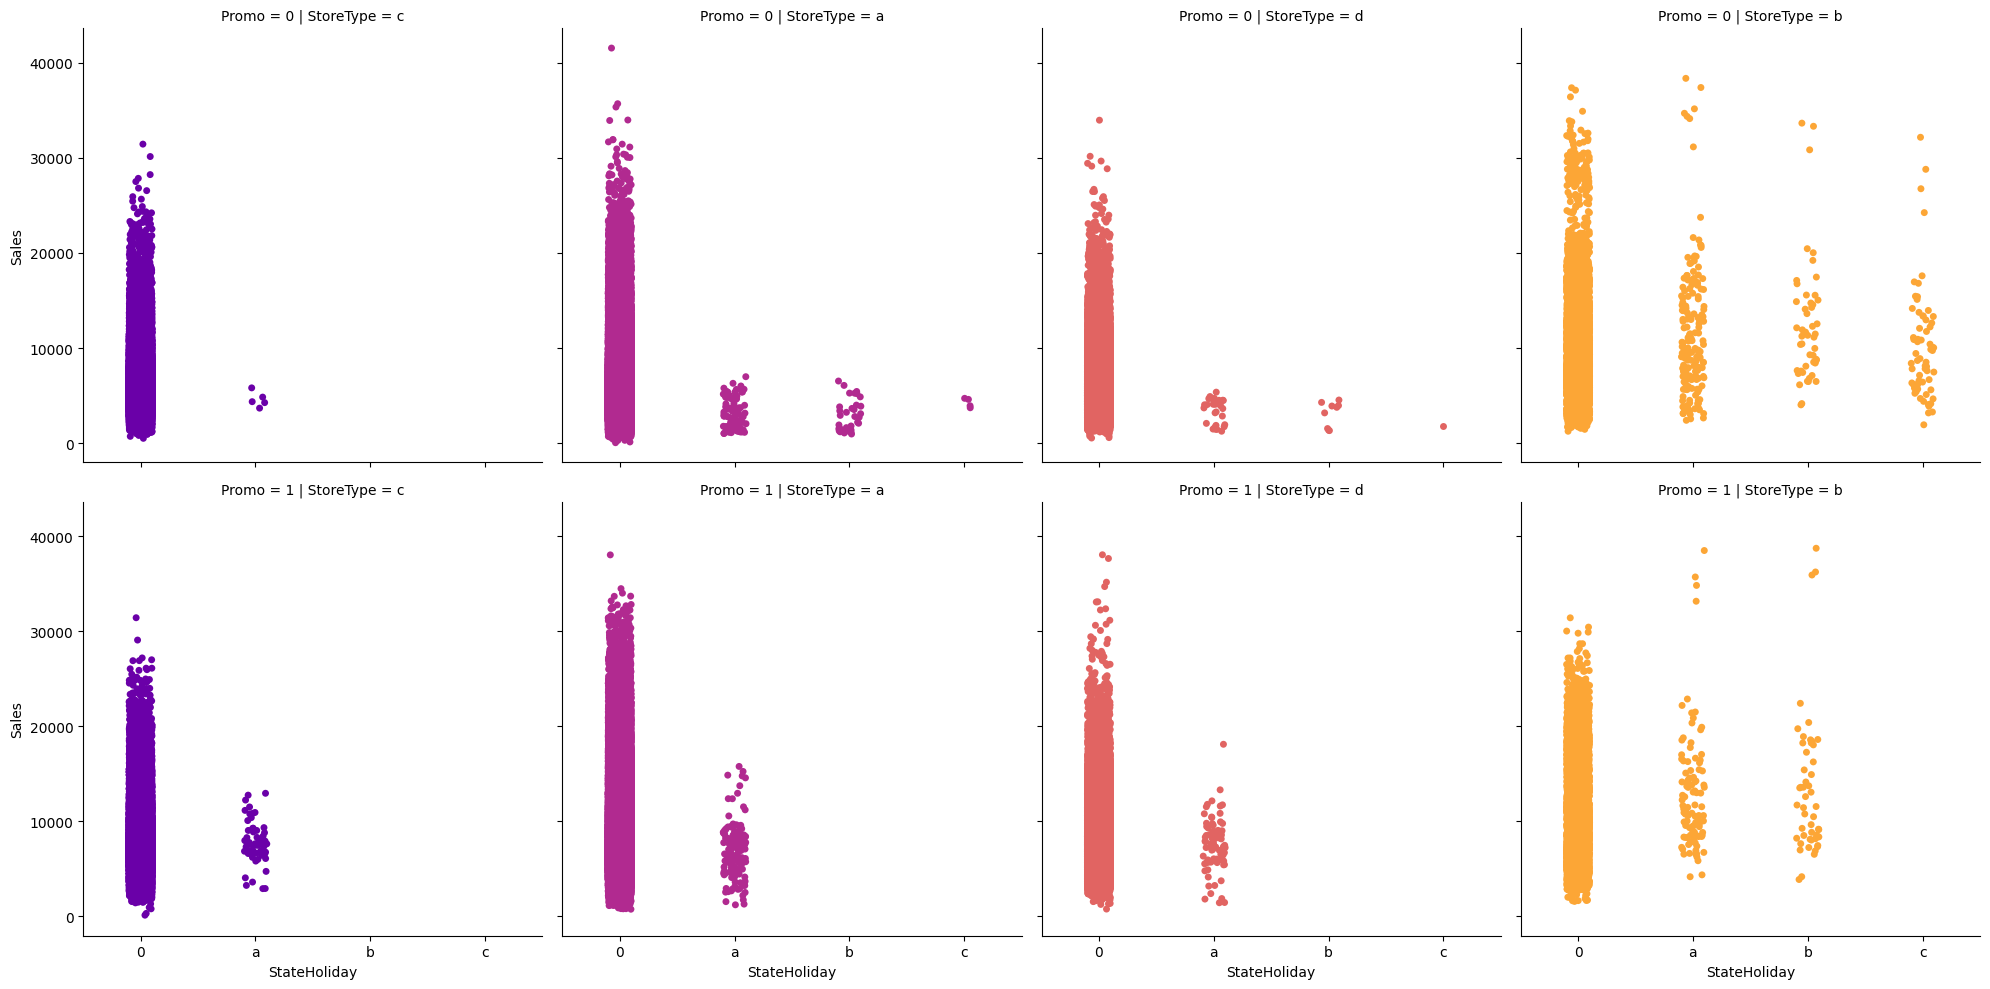

In [ ]:
sns.catplot(data = train_store_sales_df, x = 'StateHoliday', y = "Sales",
               col = 'StoreType',
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo')
#Only B type stores will be promoted on Easter, and there is no promotion on Christmas.

###Sales & SchoolHoliday & Promo & StoreType

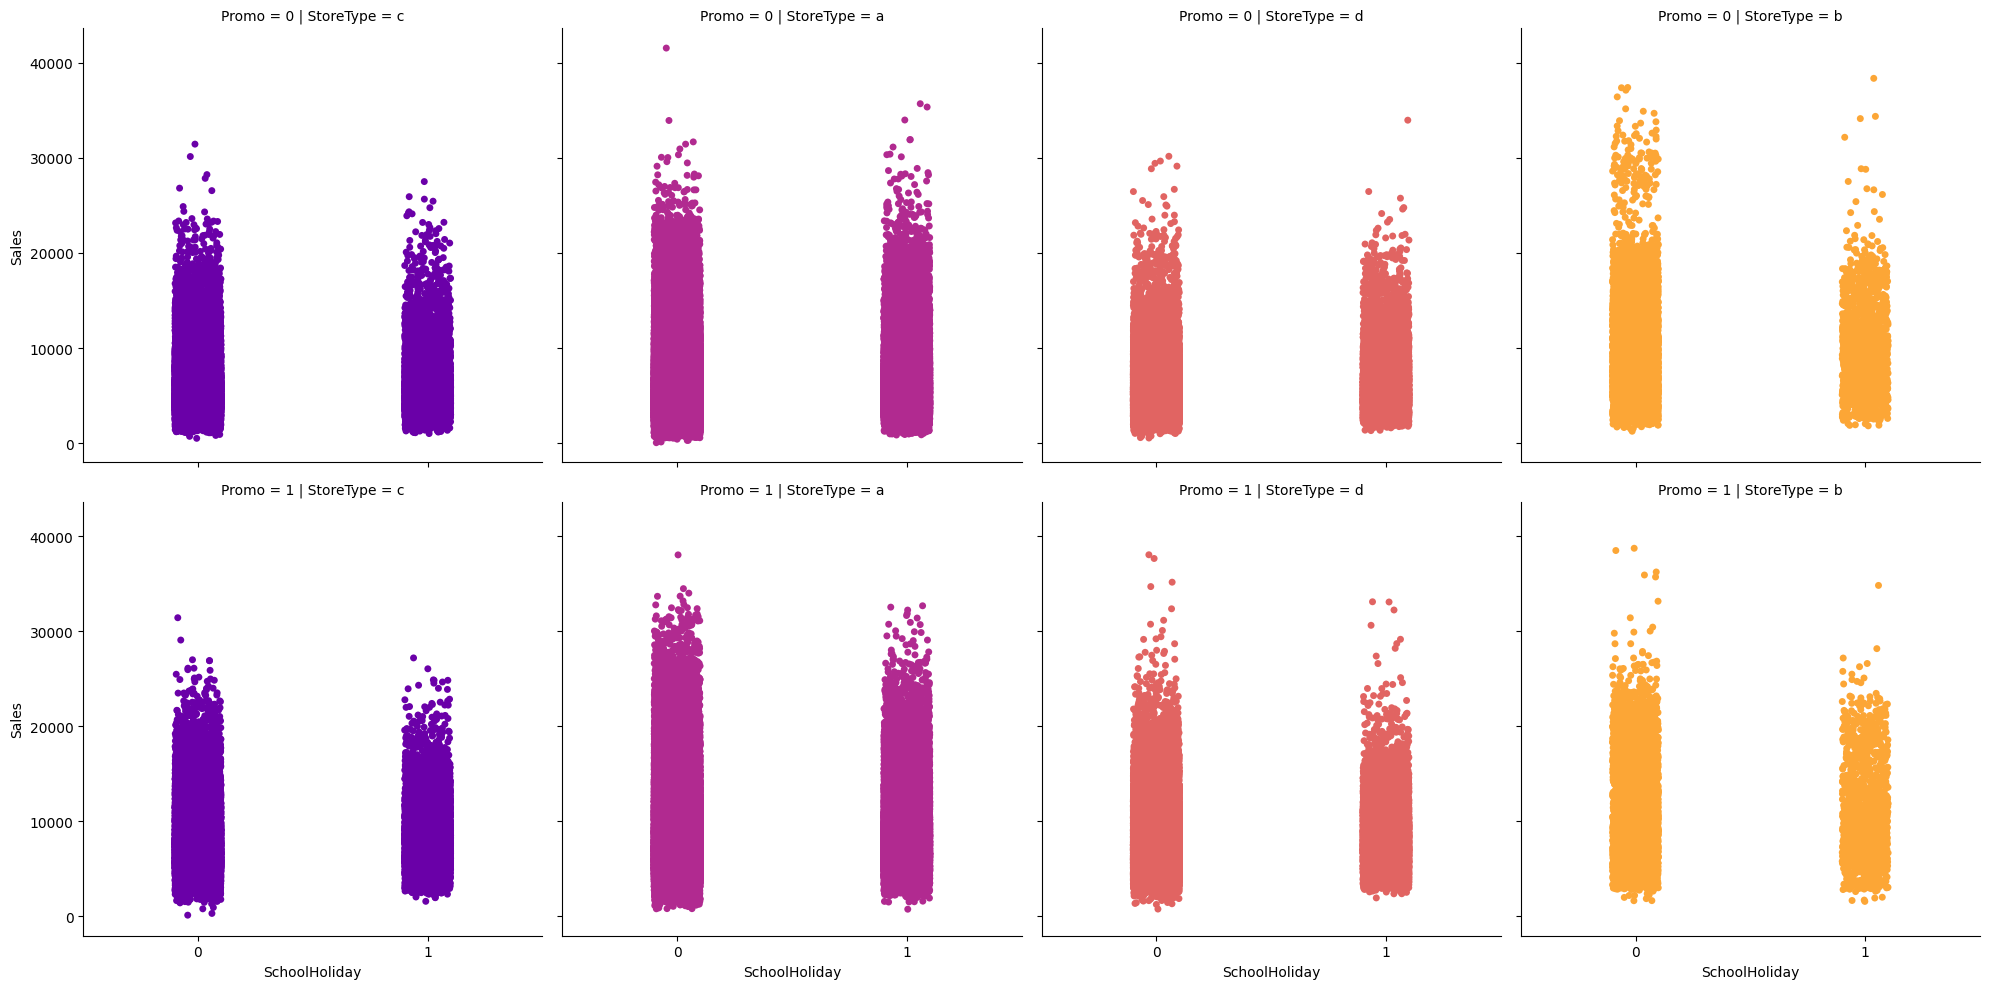

In [ ]:
sns.catplot(data = train_store_sales_df, x = 'SchoolHoliday', y = "Sales",
               col = 'StoreType',
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo')

#Feature Engineering

In [ ]:
train_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [ ]:
test_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Id                         41088 non-null  int64  
 1   Store                      41088 non-null  int64  
 2   DayOfWeek                  41088 non-null  int64  
 3   Date                       41088 non-null  object 
 4   Open                       41077 non-null  float64
 5   Promo                      41088 non-null  int64  
 6   StateHoliday               41088 non-null  object 
 7   SchoolHoliday              41088 non-null  int64  
 8   StoreType                  41088 non-null  object 
 9   Assortment                 41088 non-null  object 
 10  CompetitionDistance        40992 non-null  float64
 11  CompetitionOpenSinceMonth  25872 non-null  float64
 12  CompetitionOpenSinceYear   25872 non-null  float64
 13  Promo2                     41088 non-null  int

##Encoding

In [ ]:
#train
mappings = {'0':0,'a':1, 'b':2, 'c':3, 'd':4}
train_store_df.StateHoliday.replace(mappings, inplace=True)
train_store_df.StoreType.replace(mappings, inplace=True)
train_store_df.Assortment.replace(mappings, inplace=True)

#test
test_store_df.StateHoliday.replace(mappings, inplace=True)
test_store_df.StoreType.replace(mappings, inplace=True)
test_store_df.Assortment.replace(mappings, inplace=True)

##Choice X,y for training

In [ ]:
# Consider only open stores which Sales bigger then zero for training.
train_drop_features = ['Customers', 'Sales','CompetitionOpenSinceMonth','CompetitionOpenSinceYear',
                       'Promo2SinceWeek','Promo2SinceYear','PromoInterval']
X = train_store_df[(train_store_df.Open != 0 ) & (train_store_df.Sales != 0)].drop(train_drop_features, axis=1)
y = train_store_df[(train_store_df.Open != 0 ) & (train_store_df.Sales != 0)].Sales
y = np.log1p(y)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=23)

The number of customers who visited the store on a particular day is highly correlated with the Sales variable, which makes it a predictor rather than a feature. Since we cannot predict the number of customers in advance, we drop this variable"

A feature is an input variable or attribute used to make predictions with a predictor. A predictor uses one or more features to produce an output value, which is the predicted target value.

In [ ]:
test_drop_features = ['Id','CompetitionOpenSinceMonth','CompetitionOpenSinceYear',
                      'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']
X_test = test_store_df.drop(test_drop_features, axis=1)

#Model

Linear Regression

In [ ]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X_train , y_train)
pred = reg.predict(X_valid)

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_valid,pred))
print(rmse)


0.37126143320176086


Decision Tree Regression

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeRegressor()
clf.fit(X_train , y_train)
pred = clf.predict(X_valid)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_valid,pred))
print(rmse)

0.15910537560235818


the decision tree regressor is giving 0.1592 as RMSE which is quite good

**Ensemble Techniques**

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100,max_depth=15)

rf.fit(X_train,y_train)

rf_pred = rf.predict(X_valid)

In [ ]:
rmse_rf = np.sqrt(mean_squared_error(y_valid,rf_pred))
rmse_rf

0.20661932536138275

LightGBM

In [ ]:
# LightGBM Model
import lightgbm as lgb
lgb_model = lgb.LGBMRegressor(max_depth=10, n_estimators=1000, learning_rate=0.1, random_state=42)
lgb_model.fit(X_train, y_train)

# Predict on the validation set
y_pred_lgb = lgb_model.predict(X_valid)

# Calculate the root mean squared error (RMSE)
rmse_lgb = np.sqrt(mean_squared_error(y_valid, y_pred_lgb))

In [ ]:
rmse_lgb

0.11301976638987096

XGBoost

In [ ]:
from xgboost import XGBRegressor
xgb = XGBRegressor(max_depth=15,n_jobs=4,n_estimators=120,subsample=0.7)
xgb.fit(X_train,y_train)
xg_pred = xgb.predict(X_valid)
rmse_xgb = np.sqrt(mean_squared_error(y_valid,xg_pred))
rmse_xgb

0.0924351966100378

XGBoost Regressor achieved a considerably low RMSE of 0.0924 and did really well in this case.

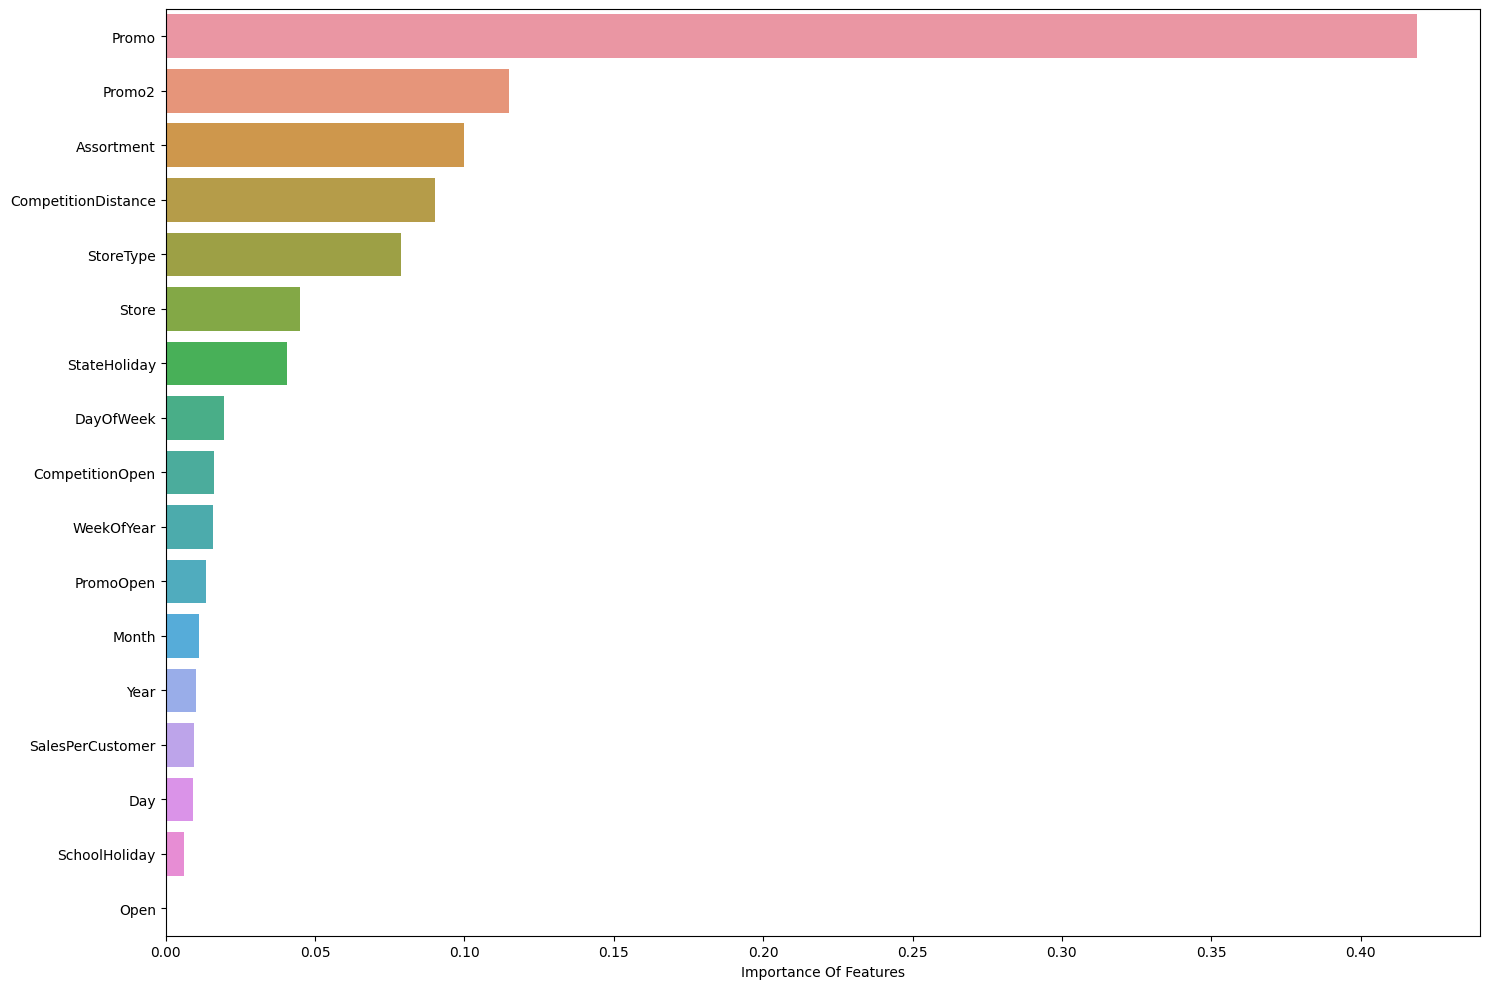

In [ ]:
from xgboost import XGBRegressor
xgb = XGBRegressor(max_depth=15,n_jobs=4,n_estimators=120,subsample=0.7)
xgb.fit(X_train,y_train)
ranks = np.argsort(-xgb.feature_importances_)
f, ax = plt.subplots(figsize=(15, 10))

sns.barplot(x=xgb.feature_importances_[ranks], y=X_train.columns.values[ranks], orient='h')
ax.set_xlabel("Importance Of Features")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
xgb = XGBRegressor(max_depth=15,n_jobs=4,n_estimators=120,subsample=0.7)
scores = cross_val_score(xgb, X , y , cv=5)
scores

Cross validations upto 5 also yielded a minimum of 0.0657which is less than any other model's RMSE.